<center><h1>Merchandise Popularity Prediction</h1></center>

<center><h2>Overview</h2><center>

Big Brands spend a significant amount on popularizing a product. Nevertheless, their efforts go in vain while establishing the merchandise in the hyperlocal market. Based on different geographical conditions same attributes can communicate a piece of much different information about the customer. Hence, insights this is a must for any brand owner.

In this competition, we have brought the data gathered from one of the top apparel brands in India. Provided the details concerning category, score, and presence in the store, participants are challenged to predict the popularity level of the merchandise.

The popularity class decides how popular the product is given the attributes which a store owner can control to make it happen.

In [1]:
import datetime
from pickle import dump, load

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from IPython.display import Image, display
from sklearnex import patch_sklearn
from tqdm.auto import tqdm

patch_sklearn()

import warnings
from pathlib import Path

import lightgbm
from imblearn import ensemble, over_sampling, under_sampling
from imblearn.metrics import (
    classification_report_imbalanced,
    sensitivity_specificity_support,
)
from prettytable import PrettyTable
from sklearn import metrics, tree
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    SelectKBest,
    VarianceThreshold,
    f_classif,
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.utils import compute_class_weight
from sklearn.utils.validation import check_is_fitted

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (10, 8)}, font_scale=1.25)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
np.random.seed(42)

<center><h2>Exploratory Data Analysis</h2><center>

### About Dataset

- **Train.csv** - `18208 x 12` (Includes popularity Column as Target variable)
- **Test.csv** - `12140 x 11` 

In [3]:
train_df = pd.read_csv("./MPP_Dataset/Train.csv")
test_df = pd.read_csv("./MPP_Dataset/Test.csv")

In [4]:
train_df.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0        0.407       0.00380           2      -35.865           1   
1        0.234       0.10500           0      -19.884           1   
2        0.668       0.72600           9       -7.512           1   
3        0.184       0.00561           4      -34.357           1   
4        0.231       0.13100           6      -22.842           1   

   Store_Presence  Score_1  Score_2  Score_3  Score_4    time  popularity  
0          0.9920    0.944   0.0988   0.1100  113.911  189125           4  
1          0.9440    0.900   0.1290   0.0382   76.332  186513           4  
2          0.0387    0.000   0.1340   0.4530  124.075  172143           4  
3          0.8490    0.931   0.1110   0.0641   79.037  184000           5  
4          0.9370    0.000   0.1090   0.0677  109.560  186507           3

In [5]:
test_df.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0        0.164         0.994           1      -23.718           0   
1        0.586         0.636           4       -7.710           1   
2        0.457         0.743           0       -7.591           1   
3        0.423         0.748           5       -9.832           1   
4        0.802         0.756           2      -10.791           0   

   Store_Presence  Score_1  Score_2  Score_3  Score_4    time  
0         0.12400  0.99100   0.7890  0.00001  127.602  236436  
1         0.00208  0.32200   0.1070  0.35500  136.337  253631  
2         0.40400  0.00931   0.2010  0.68800  154.902  215669  
3         0.03000  0.22100   0.1690  0.42800   93.977  325200  
4         0.08430  0.00765   0.0521  0.96300  131.715  288293

### Attributes in the dataset

In [6]:
train_df.columns.to_list()

['Store_Ratio',
 'Basket_Ratio',
 'Category_1',
 'Store_Score',
 'Category_2',
 'Store_Presence',
 'Score_1',
 'Score_2',
 'Score_3',
 'Score_4',
 'time',
 'popularity']

There are a total of 11 features, and the last column `popularity` is the target column. Let's have a look at it.

In [7]:
train_df.popularity.unique().tolist()

[4, 5, 3, 1, 0]

`popularity` column has 5 unique popularity values. This is a problem of multi-class classification. 

### Dataframe info

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18208 entries, 0 to 18207
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store_Ratio     18208 non-null  float64
 1   Basket_Ratio    18208 non-null  float64
 2   Category_1      18208 non-null  int64  
 3   Store_Score     18208 non-null  float64
 4   Category_2      18208 non-null  int64  
 5   Store_Presence  18208 non-null  float64
 6   Score_1         18208 non-null  float64
 7   Score_2         18208 non-null  float64
 8   Score_3         18208 non-null  float64
 9   Score_4         18208 non-null  float64
 10  time            18208 non-null  int64  
 11  popularity      18208 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12140 entries, 0 to 12139
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Store_Ratio     12140 non-null  float64
 1   Basket_Ratio    12140 non-null  float64
 2   Category_1      12140 non-null  int64  
 3   Store_Score     12140 non-null  float64
 4   Category_2      12140 non-null  int64  
 5   Store_Presence  12140 non-null  float64
 6   Score_1         12140 non-null  float64
 7   Score_2         12140 non-null  float64
 8   Score_3         12140 non-null  float64
 9   Score_4         12140 non-null  float64
 10  time            12140 non-null  int64  
dtypes: float64(8), int64(3)
memory usage: 1.0 MB


### Of Null values and missing values

In [10]:
train_df.isna().sum()

Store_Ratio       0
Basket_Ratio      0
Category_1        0
Store_Score       0
Category_2        0
Store_Presence    0
Score_1           0
Score_2           0
Score_3           0
Score_4           0
time              0
popularity        0
dtype: int64

*Obvservation*

- No null or missing values in train dataset

In [11]:
test_df.isna().sum()

Store_Ratio       0
Basket_Ratio      0
Category_1        0
Store_Score       0
Category_2        0
Store_Presence    0
Score_1           0
Score_2           0
Score_3           0
Score_4           0
time              0
dtype: int64

*Obvservation*
- No null or missing values in test dataset 

### Basic Statistics at glance 

In [12]:
train_df.describe()

Store_Ratio  Basket_Ratio    Category_1   Store_Score    Category_2  \
count  18208.000000  18208.000000  18208.000000  18208.000000  18208.000000   
mean       0.544283      0.483585      5.155536    -12.198086      0.648506   
std        0.202709      0.302010      3.535068      8.370566      0.477450   
min        0.000000      0.000216      0.000000    -47.576000      0.000000   
25%        0.411000      0.200000      2.000000    -16.496250      0.000000   
50%        0.573000      0.517000      5.000000     -9.166500      1.000000   
75%        0.699000      0.742000      8.000000     -5.943750      1.000000   
max        0.998000      1.000000     11.000000     -0.079000      1.000000   

       Store_Presence       Score_1       Score_2       Score_3       Score_4  \
count    18208.000000  18208.000000  18208.000000  18208.000000  18208.000000   
mean         0.477702      0.322109      0.164888      0.421440    115.305776   
std          0.380634      0.413493      0.136531      0.271922     31.478303   
min          0.000000      0.000000      0.011900      0.000000      0.000000   
25%          0.086175      0.000001      0.095300      0.184750     90.974250   
50%          0.430000      0.002245      0.112000      0.393000    114.022500   
75%          0.895000      0.859000      0.176000      0.640000    134.997000   
max          0.996000      1.000000      0.991000      0.999000    219.701000   

               time    popularity  
count  1.820800e+04  18208.000000  
mean   2.180101e+05      3.850231  
std    9.648289e+04      0.544226  
min    3.184400e+04      0.000000  
25%    1.696202e+05      4.000000  
50%    2.046460e+05      4.000000  
75%    2.471562e+05      4.000000  
max    3.908467e+06      5.000000

In [13]:
test_df.describe()

Store_Ratio  Basket_Ratio    Category_1   Store_Score    Category_2  \
count  12140.000000  12140.000000  12140.000000  12140.000000  12140.000000   
mean       0.543776      0.488879      5.121417    -12.062847      0.642916   
std        0.200109      0.301217      3.528765      8.300385      0.479160   
min        0.000000      0.000000      0.000000    -46.847000      0.000000   
25%        0.414750      0.213000      2.000000    -16.066000      0.000000   
50%        0.570000      0.521000      5.000000     -9.046500      1.000000   
75%        0.696000      0.745000      8.000000     -5.891750      1.000000   
max        0.978000      1.000000     11.000000      0.662000      1.000000   

       Store_Presence       Score_1       Score_2       Score_3       Score_4  \
count    12140.000000  12140.000000  12140.000000  12140.000000  12140.000000   
mean         0.474675      0.321641      0.165942      0.420485    115.748041   
std          0.377582      0.414438      0.139109      0.270508     31.519999   
min          0.000000      0.000000      0.000000      0.000000      0.000000   
25%          0.087775      0.000001      0.095900      0.190000     90.908750   
50%          0.430500      0.002050      0.112000      0.392000    114.618500   
75%          0.882000      0.861000      0.173250      0.633000    135.829250   
max          0.996000      1.000000      0.994000      1.000000    219.701000   

               time  
count  1.214000e+04  
mean   2.154031e+05  
std    8.231108e+04  
min    3.406700e+04  
25%    1.700000e+05  
50%    2.043415e+05  
75%    2.445222e+05  
max    1.782178e+06

Let's begin with some basic EDA

### Count of popularity values (our target)

In [14]:
train_df.popularity.value_counts().sort_values()

0       16
1      323
5      472
3     2166
4    15231
Name: popularity, dtype: int64

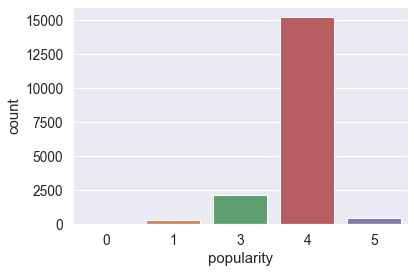

In [15]:
_ = sns.countplot(data=train_df, x="popularity")

*Observation*

- Highly imbalanced dataset
- Minority class - `0` with only 16 values
- Majority class - `4` with 15231 values

### Univariate analysis

Small utility function which will help us to plot our feature distributions

In [16]:
def plot_all_feats(df=None, typ="hist", title="Features and their distributions"):
    """
    This function can be used to plot all the features in the
    dataset as subplots with a specific type of plot.

    Currently supported plots : {'hist', 'bar', 'kde', 'box'}

    Parameters
    ----------
    df: pd.Dataframe
        The dataframe

    typ: str {'hist', 'bar', 'kde', 'box'}
        The type of plot to be used

    title: str
        Title of the complete Figure.
    """

    types = {
        "hist": sns.histplot,
        "bar": sns.barplot,
        "kde": sns.kdeplot,
        "box": sns.boxplot,
        "violin": sns.violinplot,
        "boxen": sns.boxenplot,
    }

    if typ not in types:
        print(f"[Error] Plot is not defined, choose from {list(types.keys())}")
    else:

        fig, axes = plt.subplots(4, 3)
        fig.suptitle(title)
        fig.set_size_inches(15, 15, forward=True)
        fig.subplots_adjust(hspace=0.5)

        FEATURE_COLUMNS = df.columns.to_list()

        k = 0
        for i in range(4):
            for j in range(3):
                types[typ](ax=axes[i, j], data=df, x=FEATURE_COLUMNS[k]).set(
                    ylabel=None
                )
                k += 1

#### Histogram for features

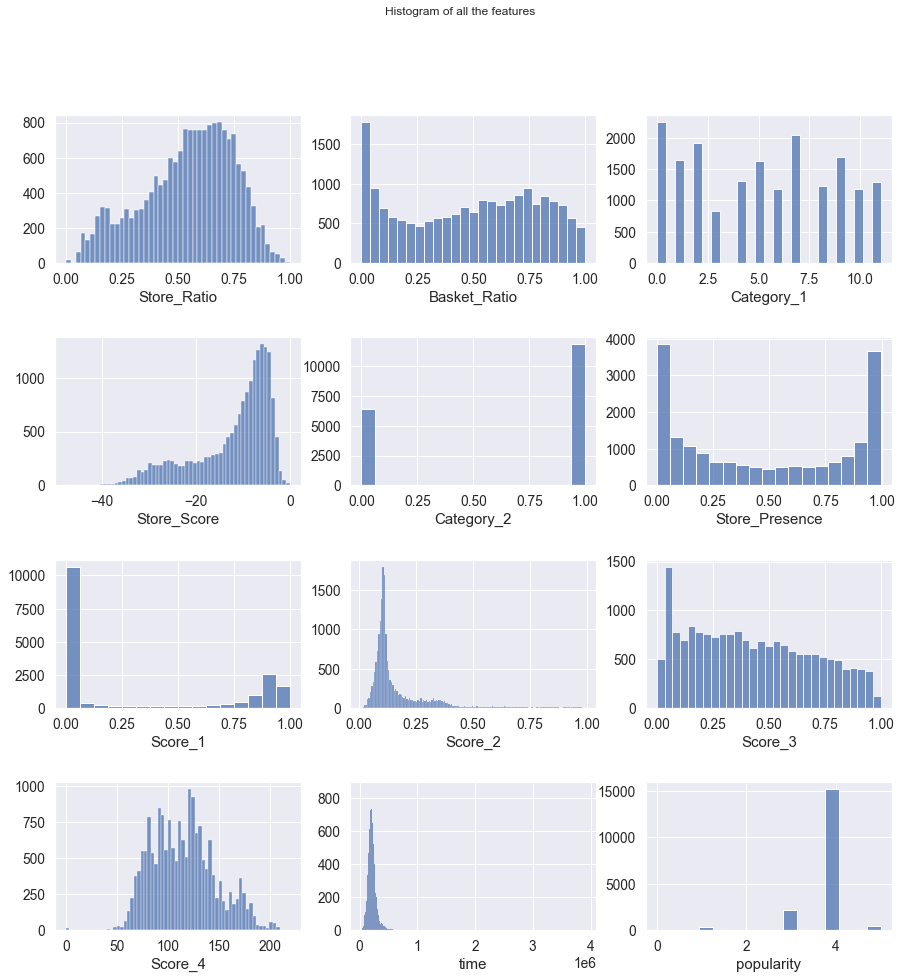

In [17]:
plot_all_feats(df=train_df, typ="hist", title="Histogram of all the features")

#### KDE plots for all features

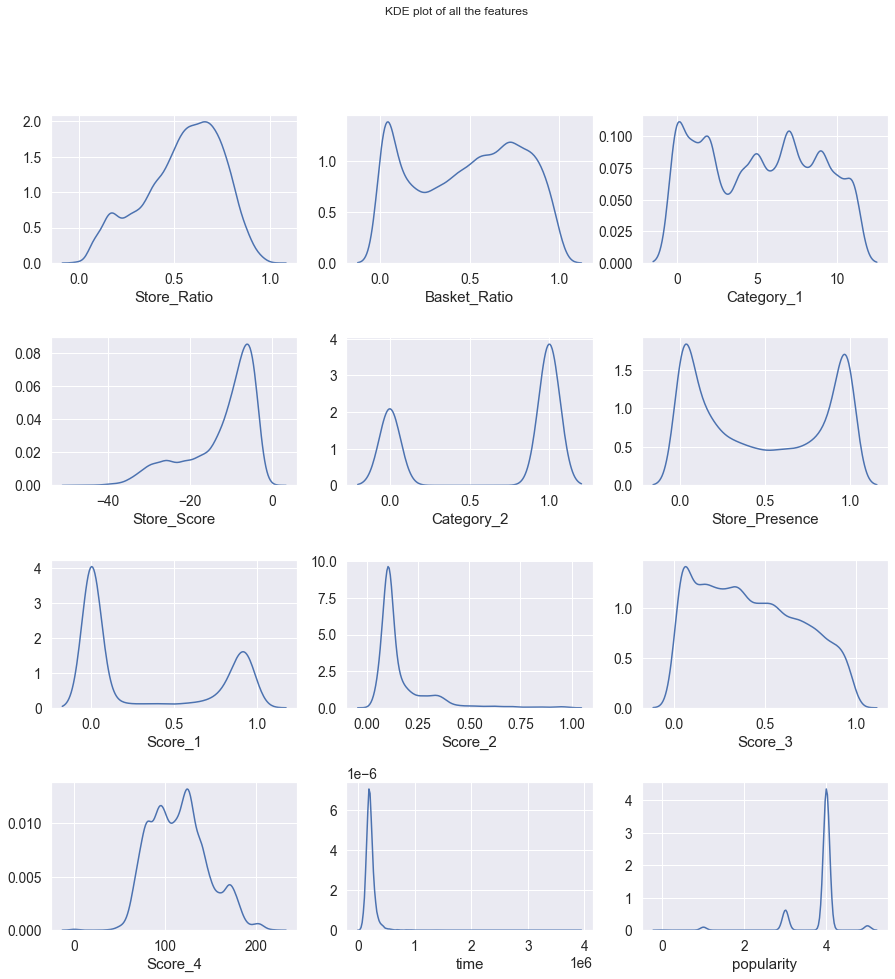

In [18]:
plot_all_feats(df=train_df, typ="kde", title="KDE plot of all the features")

*Obvservation*
- We can see that `Store_Presence` has a bimodal distribution
- `Score_2` & `time` are left skewed
- `Store_Score` is right skewed
- `Category_2` has only two kinds of values 1 or 0 (kind of like an encoded categorical variable)
- `Category_1` also has discreet values (we will look at them individually)
- `Store_Ratio`, `Basket_Ratio`, `Score_1`, `Score_2`, `Score_3` all of them have values ranging from 0 to 1

Checking out unique values in **`Category_1`**

In [19]:
train_df.Category_1.unique()

array([ 2,  0,  9,  4,  6,  3, 10,  5,  8,  1,  7, 11], dtype=int64)

`Category_1` has 12 unique values

#### Boxplots for all features

****************************************
From BOX-PLOT we can infer the following
****************************************


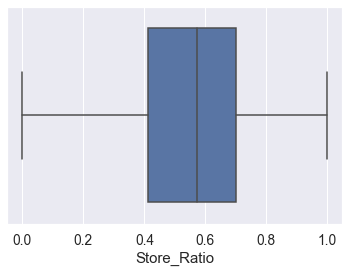

Column: Store_Ratio
--------------------
Mean => 0.544
25% values are less than => 0.411
75% values are less than => 0.699
Inter-Quartile-Range => 0.288


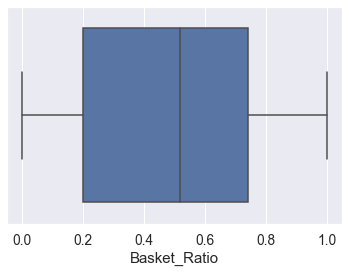

Column: Basket_Ratio
--------------------
Mean => 0.484
25% values are less than => 0.2
75% values are less than => 0.742
Inter-Quartile-Range => 0.542


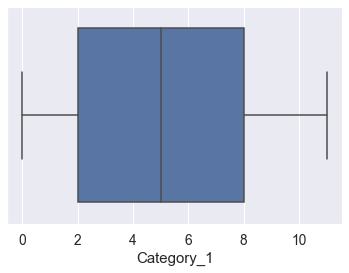

Column: Category_1
--------------------
Mean => 5.156
25% values are less than => 2.0
75% values are less than => 8.0
Inter-Quartile-Range => 6.0


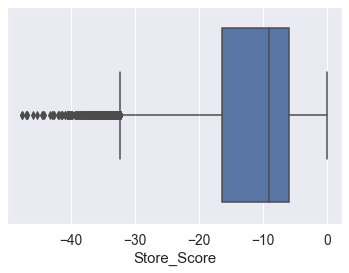

Column: Store_Score
--------------------
Mean => -12.198
25% values are less than => -16.496
75% values are less than => -5.944
Inter-Quartile-Range => 10.552


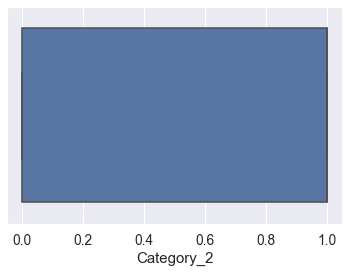

Column: Category_2
--------------------
Mean => 0.649
25% values are less than => 0.0
75% values are less than => 1.0
Inter-Quartile-Range => 1.0


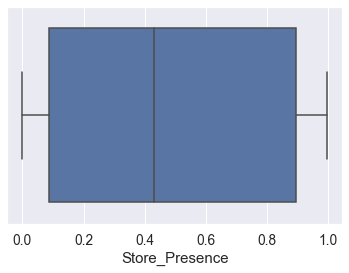

Column: Store_Presence
--------------------
Mean => 0.478
25% values are less than => 0.086
75% values are less than => 0.895
Inter-Quartile-Range => 0.809


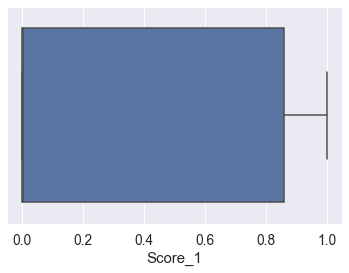

Column: Score_1
--------------------
Mean => 0.322
25% values are less than => 0.0
75% values are less than => 0.859
Inter-Quartile-Range => 0.859


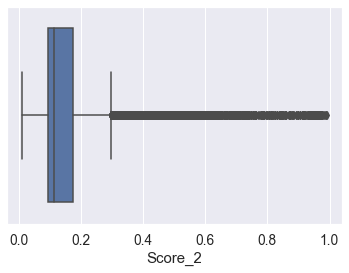

Column: Score_2
--------------------
Mean => 0.165
25% values are less than => 0.095
75% values are less than => 0.176
Inter-Quartile-Range => 0.081


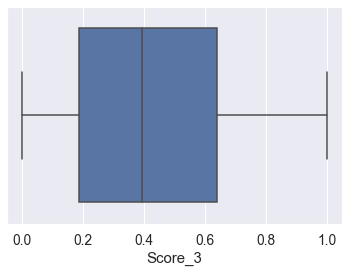

Column: Score_3
--------------------
Mean => 0.421
25% values are less than => 0.185
75% values are less than => 0.64
Inter-Quartile-Range => 0.455


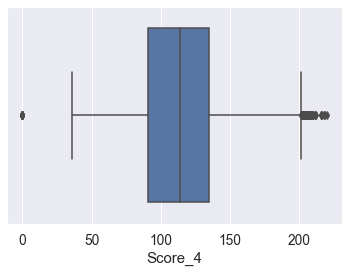

Column: Score_4
--------------------
Mean => 115.306
25% values are less than => 90.974
75% values are less than => 134.997
Inter-Quartile-Range => 44.023


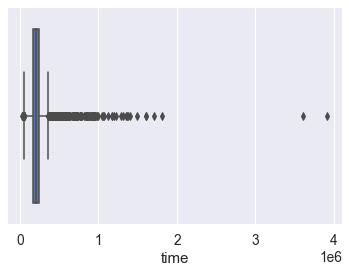

Column: time
--------------------
Mean => 218010.143
25% values are less than => 169620.25
75% values are less than => 247156.25
Inter-Quartile-Range => 77536.0


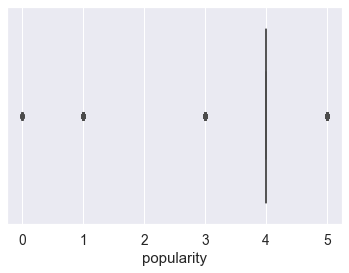

Column: popularity
--------------------
Mean => 3.85
25% values are less than => 4.0
75% values are less than => 4.0
Inter-Quartile-Range => 0.0


In [20]:
print("*" * 40)
print("From BOX-PLOT we can infer the following")
print("*" * 40)

for col in train_df.columns.to_list():
    _ = sns.boxplot(data=train_df, x=col)
    plt.show()
    q1 = train_df[col].quantile(0.25)
    q2 = train_df[col].quantile(0.75)
    iqr = q2 - q1
    print(("=" * 40))
    print(f"Column: {col}")
    print(("-" * 20))
    print(f"Mean => {round(train_df[col].mean(), 3)}")
    print(f"25% values are less than => {round(q1, 3)}")
    print(f"75% values are less than => {round(q2, 3)}")
    print(f"Inter-Quartile-Range => {round(iqr, 3)}")
    print(("=" * 40))

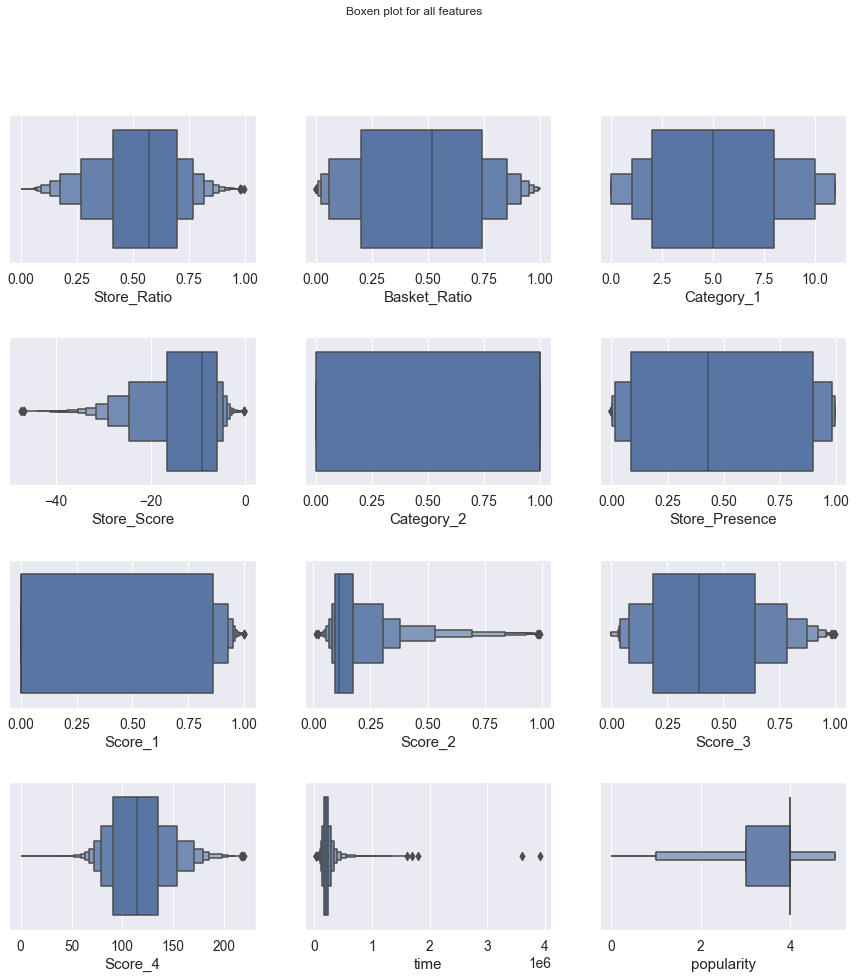

In [21]:
plot_all_feats(df=train_df, typ="boxen", title="Boxen plot for all features")

*Obvservation*
- For our skewed features `Score_2` & `Store_Presence` we can see that the tails doesn't fall off as sharply. 
- It falls off rather smoothly, unlike incase of `time` where the tail is rather sharp

Same can be seen with the violin plots too

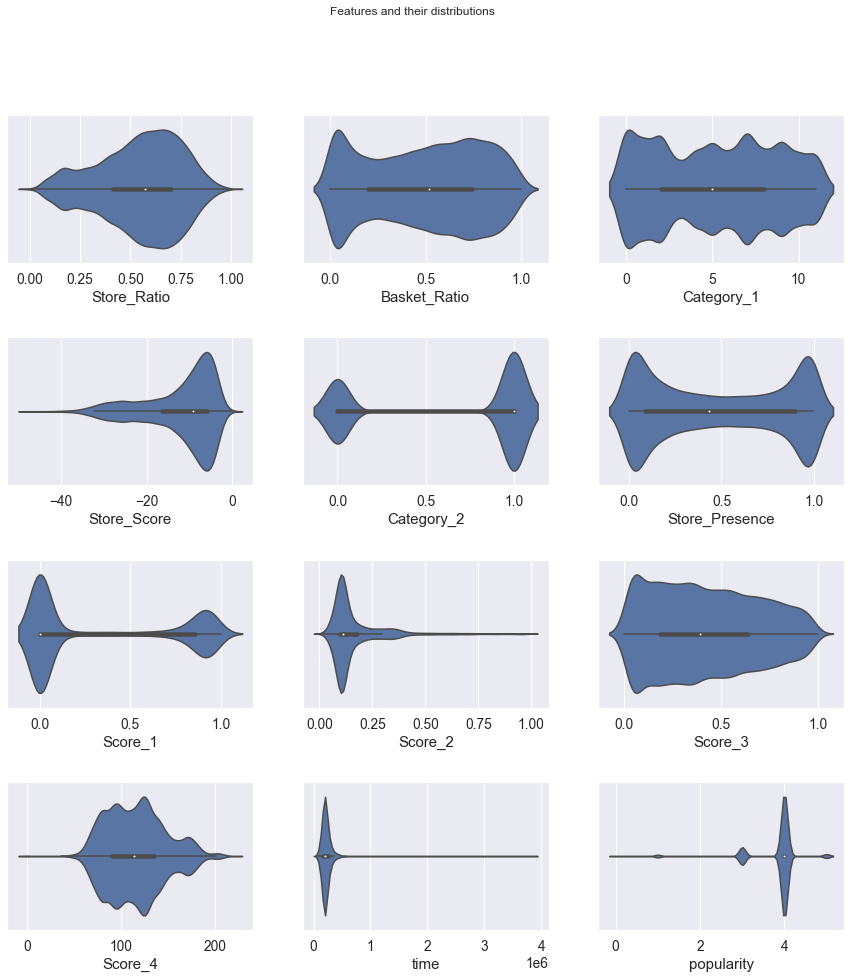

In [22]:
plot_all_feats(train_df, "violin")

### Bivariate Analysis

#### Pair plot

In [23]:
# _ = sns.pairplot(train_df.iloc[:1000, :], palette='bright', hue='popularity')

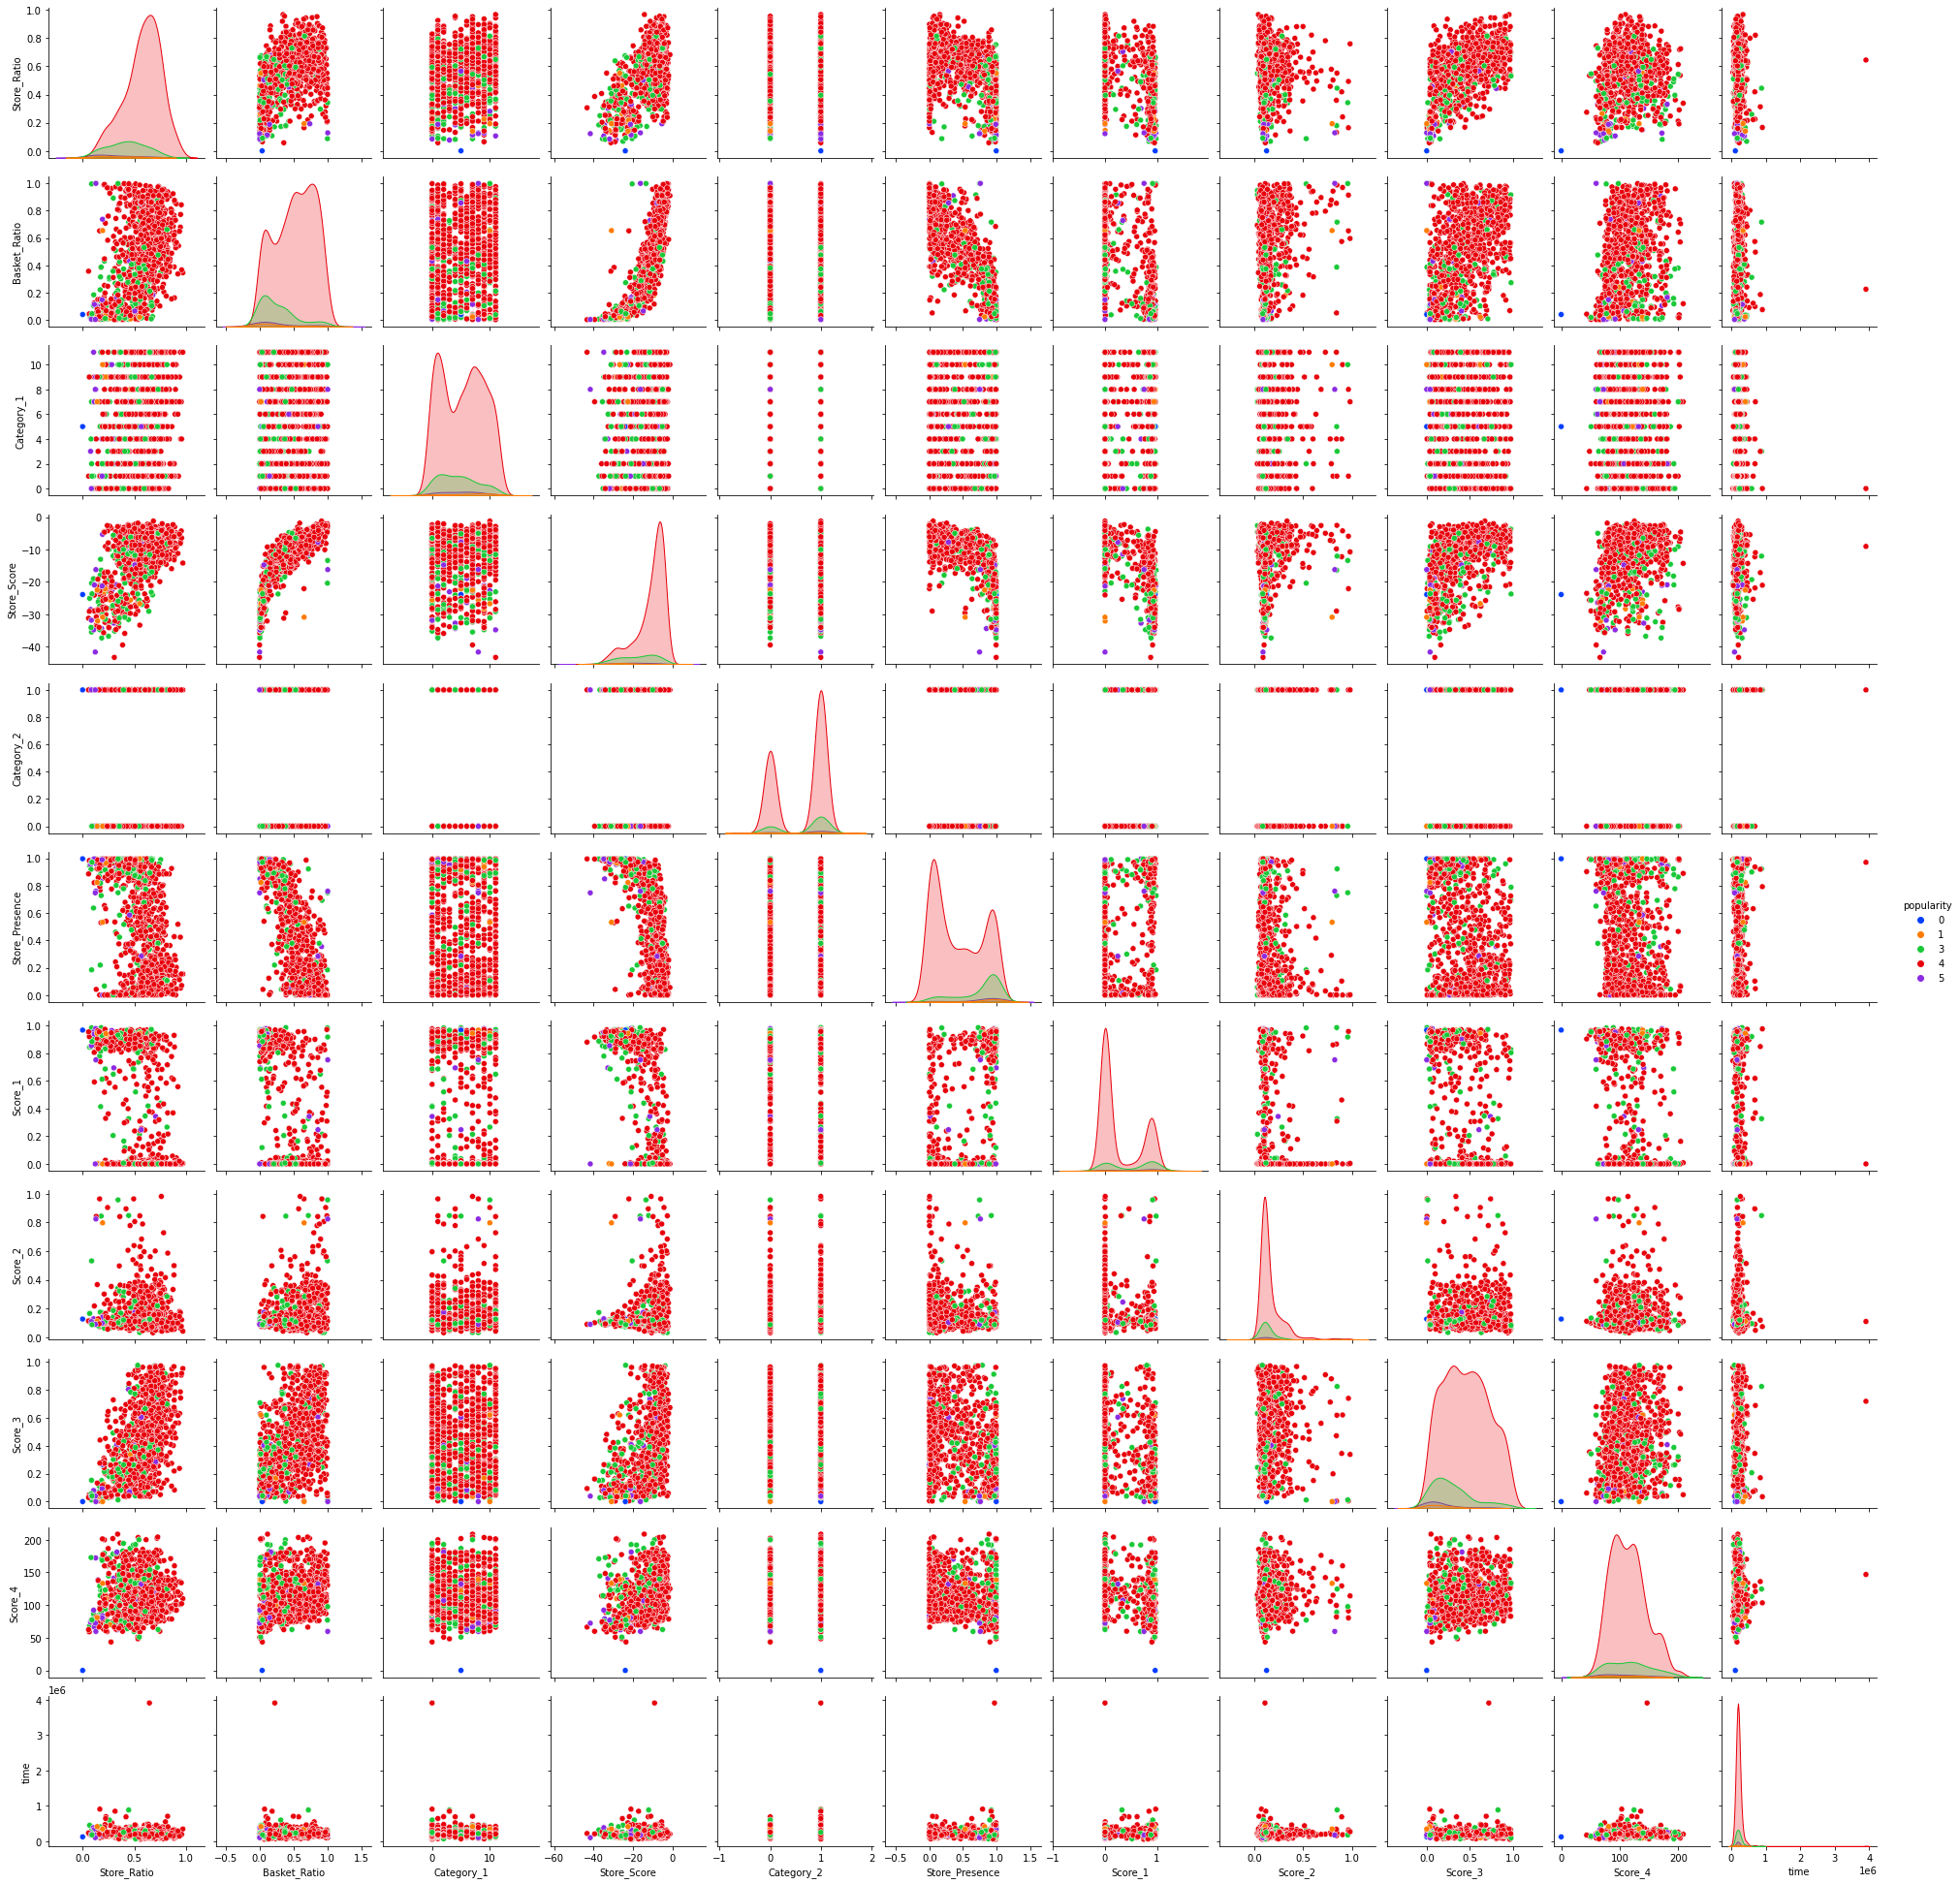

In [24]:
display(Image("pairplot.png"))

*Obvservation*
- `Store_Score` & `Store_Presence` have negative correlation as we can see that as `Store_Presence` value increases the the `Store_Score` decreases.
- `Store_Score` & `Basket_Ratio` have positive correlatin as we can see that as the value of `Basket_Ratio` increases the `Store_Score` decreases
- There also other correlations

To understand the strength of correlations we will move on to correlation analysis

### Correlation Analysis

In [25]:
corr = train_df.corr()
corr

Store_Ratio  Basket_Ratio  Category_1  Store_Score  \
Store_Ratio        1.000000      0.465598    0.040335     0.599820   
Basket_Ratio       0.465598      1.000000    0.051739     0.826055   
Category_1         0.040335      0.051739    1.000000     0.042988   
Store_Score        0.599820      0.826055    0.042988     1.000000   
Category_2        -0.102391     -0.114843   -0.139914    -0.085984   
Store_Presence    -0.471475     -0.821807   -0.046474    -0.723449   
Score_1           -0.454113     -0.612220   -0.028973    -0.726385   
Score_2           -0.039416      0.275749    0.019738     0.145093   
Score_3            0.620874      0.527086    0.036477     0.516937   
Score_4            0.119472      0.253789    0.003057     0.263739   
time              -0.063763      0.101478   -0.012886     0.080659   
popularity         0.232888      0.200988    0.003716     0.204896   

                Category_2  Store_Presence   Score_1   Score_2   Score_3  \
Store_Ratio      -0.102391       -0.471475 -0.454113 -0.039416  0.620874   
Basket_Ratio     -0.114843       -0.821807 -0.612220  0.275749  0.527086   
Category_1       -0.139914       -0.046474 -0.028973  0.019738  0.036477   
Store_Score      -0.085984       -0.723449 -0.726385  0.145093  0.516937   
Category_2        1.000000        0.104456  0.020086 -0.036357 -0.043944   
Store_Presence    0.104456        1.000000  0.571346 -0.190961 -0.431723   
Score_1           0.020086        0.571346  1.000000 -0.104020 -0.474795   
Score_2          -0.036357       -0.190961 -0.104020  1.000000  0.033445   
Score_3          -0.043944       -0.431723 -0.474795  0.033445  1.000000   
Score_4          -0.046058       -0.222663 -0.201852  0.019435  0.181573   
time             -0.009798       -0.072484 -0.113319 -0.002480  0.009258   
popularity       -0.034565       -0.195113 -0.163667  0.001737  0.176765   

                 Score_4      time  popularity  
Store_Ratio     0.119472 -0.063763    0.232888  
Basket_Ratio    0.253789  0.101478    0.200988  
Category_1      0.003057 -0.012886    0.003716  
Store_Score     0.263739  0.080659    0.204896  
Category_2     -0.046058 -0.009798   -0.034565  
Store_Presence -0.222663 -0.072484   -0.195113  
Score_1        -0.201852 -0.113319   -0.163667  
Score_2         0.019435 -0.002480    0.001737  
Score_3         0.181573  0.009258    0.176765  
Score_4         1.000000  0.026966    0.043677  
time            0.026966  1.000000    0.020172  
popularity      0.043677  0.020172    1.000000

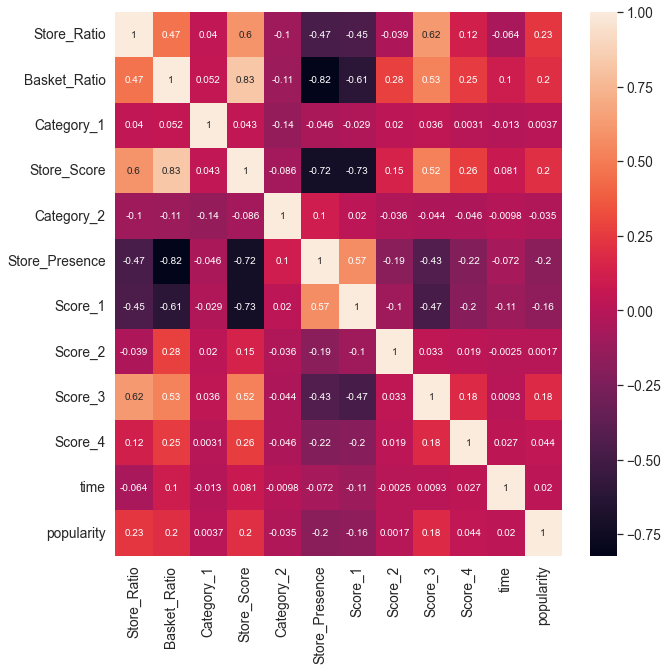

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr, annot=True)

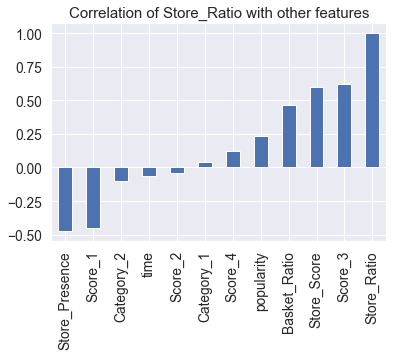

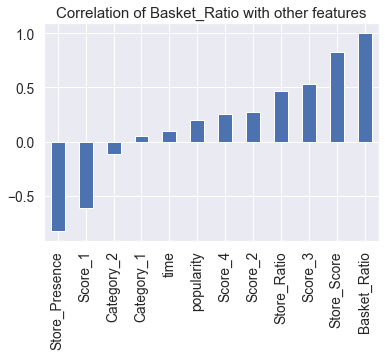

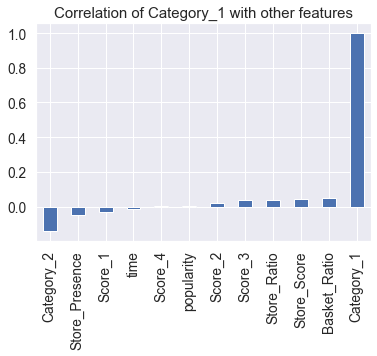

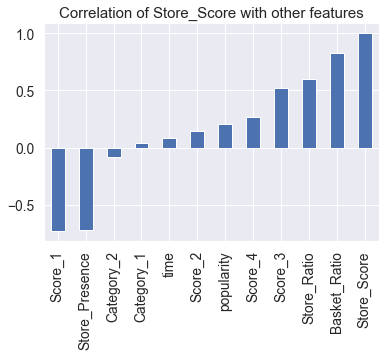

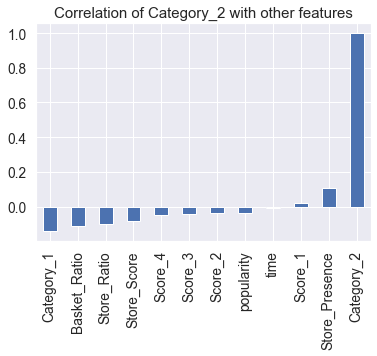

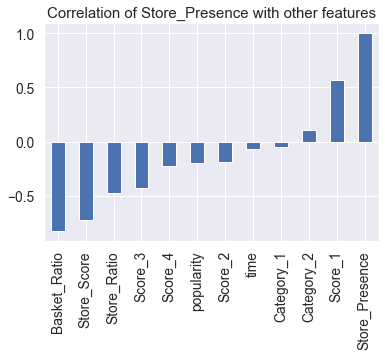

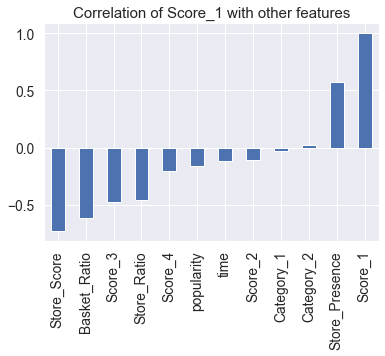

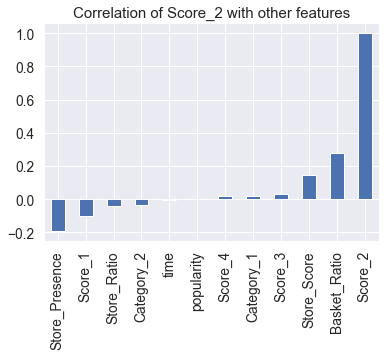

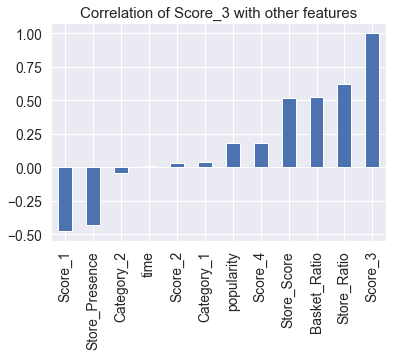

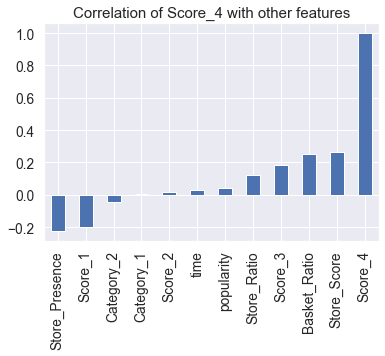

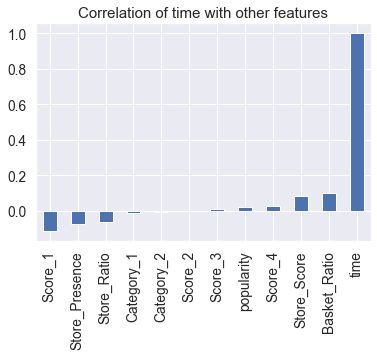

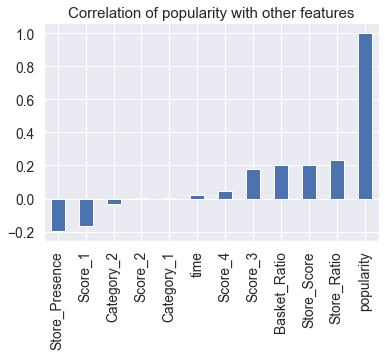

In [27]:
for col in corr.columns:
    corr[col].sort_values().plot.bar()
    plt.title(f"Correlation of {col} with other features")
    plt.show()

*Obvservation*

- `Store_Ratio` is strongly correlated with `Basket_Ratio`, `Store_Score`, `Score_3` , `Store_Presence`, `Score1`, `Score_3`
- `Basket_Ratio` is correlatd to `Store_Score`, `Store_Presence`, `Score_1`, `Score_3`.
- `Category_1` is correlated with `Category_2`
- `Score_Presence` is correlated with `Score_1`, `Score_2`, `Score_3`, `popularity`
- `Score_1` is correlated with `Score_3`, `Score_4`, `time`, `popularity`

## Feature Engineering

Now that we have seen that a lot of features are correlated to one another, let's see if we can describe our data still by reducing the features

### `time` feature

Before that we have a feature called `time`. Let's see what it is and if we can convert it into something else

In [28]:
time_feat = train_df["time"]
time_feat.head()

0    189125
1    186513
2    172143
3    184000
4    186507
Name: time, dtype: int64

This feature contains timestamps. Let's convert them into something more meaningful. Let's see the first one

In [29]:
x = datetime.datetime.fromtimestamp(time_feat[0])
str(x)

'1970-01-03 10:02:05'

This maps onto the date: 3rd of jan, 1970 at 10:02 am. Now let's look into the whole column

In [30]:
times = []
for t in time_feat:
    current = str(datetime.datetime.fromtimestamp(t))
    times.append(current[: current.index(" ")])

In [31]:
np.unique(times)

array(['1970-01-01', '1970-01-02', '1970-01-03', '1970-01-04',
       '1970-01-05', '1970-01-06', '1970-01-07', '1970-01-08',
       '1970-01-09', '1970-01-10', '1970-01-11', '1970-01-12',
       '1970-01-13', '1970-01-14', '1970-01-15', '1970-01-16',
       '1970-01-17', '1970-01-18', '1970-01-19', '1970-01-20',
       '1970-01-22', '1970-02-11', '1970-02-15'], dtype='<U10')

*Obvservation*
- We can see that we have time data for the months of january and february for the year 1970. 

In [32]:
# making a copy of train_df
train_df_copy = train_df.copy(deep=True)

In [33]:
# Creating new columns for week, day, hour
train_df_copy["weekday"] = train_df_copy.time.map(
    lambda x: datetime.datetime.fromtimestamp(x).weekday()
)
train_df_copy["day"] = train_df_copy.time.map(
    lambda x: datetime.datetime.fromtimestamp(x).day
)
train_df_copy["hour"] = train_df_copy.time.map(
    lambda x: datetime.datetime.fromtimestamp(x).hour
)

In [34]:
train_df_copy.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0        0.407       0.00380           2      -35.865           1   
1        0.234       0.10500           0      -19.884           1   
2        0.668       0.72600           9       -7.512           1   
3        0.184       0.00561           4      -34.357           1   
4        0.231       0.13100           6      -22.842           1   

   Store_Presence  Score_1  Score_2  Score_3  Score_4    time  popularity  \
0          0.9920    0.944   0.0988   0.1100  113.911  189125           4   
1          0.9440    0.900   0.1290   0.0382   76.332  186513           4   
2          0.0387    0.000   0.1340   0.4530  124.075  172143           4   
3          0.8490    0.931   0.1110   0.0641   79.037  184000           5   
4          0.9370    0.000   0.1090   0.0677  109.560  186507           3   

   weekday  day  hour  
0        5    3    10  
1        5    3     9  
2        5    3     5  
3        5    3     8  
4        5    3     9

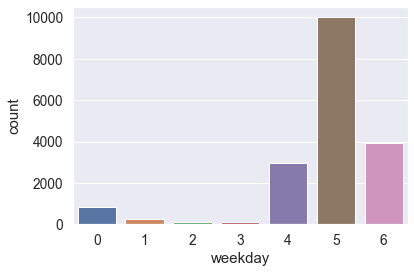

In [35]:
_ = sns.countplot(data=train_df_copy, x="weekday")

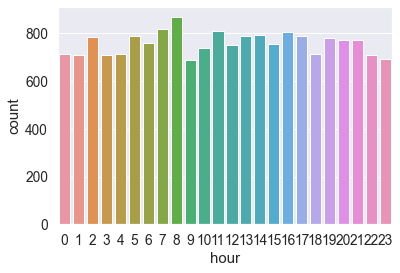

In [36]:
_ = sns.countplot(data=train_df_copy, x="hour")

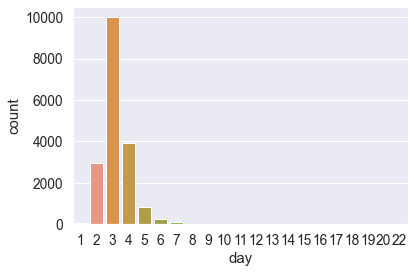

In [37]:
_ = sns.countplot(data=train_df_copy, x="day")

*Obvservation*
- 3rd January, 1970 seems to be a special day
- A lot of merchandises were purchased on this day. It was a saturday
- What were the merchandies bought for I wonder ?

In [38]:
corr_train_df_copy = train_df_copy.corr()

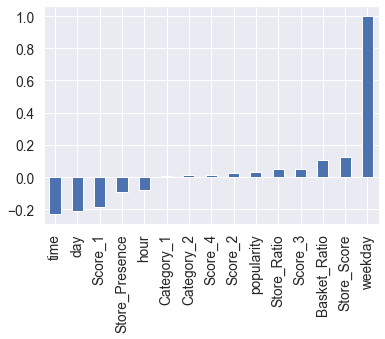

In [39]:
_ = corr_train_df_copy["weekday"].sort_values().plot.bar()

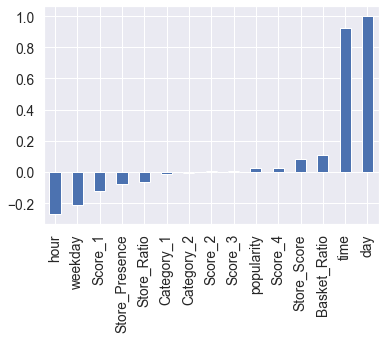

In [40]:
_ = corr_train_df_copy["day"].sort_values().plot.bar()

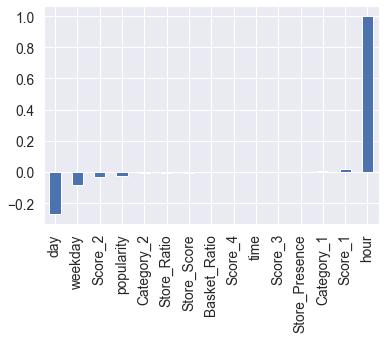

In [41]:
_ = corr_train_df_copy["hour"].sort_values().plot.bar()

*Obvservation*
- All our three new columns `day`, `weekday` & `hour` have little to no correlation with other features
- I am going to drop the time feature from the dataset now that we have 3 new features derived from time
- The new features give a better idea about our data. We see that 3rd jan, 1970 seems to be an important day with most values pertaining to this day

In [42]:
train_df_copy.drop("time", axis=1, inplace=True)

In [43]:
train_df_copy.to_csv(
    "./Feature_files/All_features_with_basic_time_feats.csv", index=False
)

## Feature Selection

In [44]:
scaler = MinMaxScaler(feature_range=(1, 10))

In [45]:
X = train_df_copy.drop("popularity", axis=1)
y = train_df_copy["popularity"]

In [46]:
X.shape, y.shape

((18208, 13), (18208,))

In [47]:
X_scaled = scaler.fit_transform(X)

In [48]:
FEATURE_COLS = train_df_copy.columns.to_list()
FEATURE_COLS.remove("popularity")

In [49]:
X_scaled_df = pd.DataFrame(X_scaled, columns=FEATURE_COLS)
X_scaled_df.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0     4.670341      1.032263    2.636364     3.219066        10.0   
1     3.110220      1.943260    1.000000     6.247237        10.0   
2     7.024048      7.533467    8.363636     8.591553        10.0   
3     2.659319      1.048556    4.272727     3.504811        10.0   
4     3.083166      2.177310    5.909091     5.686738        10.0   

   Store_Presence  Score_1   Score_2   Score_3   Score_4  weekday       day  \
0        9.963855    9.496  1.798795  1.990991  5.666337      8.5  1.857143   
1        9.530120    9.100  2.076397  1.344144  4.126922      8.5  1.857143   
2        1.349699    1.000  2.122357  5.081081  6.082703      8.5  1.857143   
3        8.671687    9.379  1.910939  1.577477  4.237732      8.5  1.857143   
4        9.466867    1.000  1.892554  1.609910  5.488100      8.5  1.857143   

       hour  
0  4.913043  
1  4.521739  
2  2.956522  
3  4.130435  
4  4.521739

### Variance Thresholding

In [50]:
vt = VarianceThreshold(threshold=1)

In [51]:
X_scaled_vt = vt.fit_transform(X_scaled_df)

In [52]:
np.array(FEATURE_COLS)[vt.get_support()]

array(['Store_Ratio', 'Basket_Ratio', 'Category_1', 'Store_Score',
       'Category_2', 'Store_Presence', 'Score_1', 'Score_2', 'Score_3',
       'Score_4', 'weekday', 'hour'], dtype='<U14')

In [53]:
X_scaled_vt_df = pd.concat(
    [train_df_copy[np.array(FEATURE_COLS)[vt.get_support()]], train_df_copy.popularity],
    axis=1,
)

In [54]:
X_scaled_vt_df.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0        0.407       0.00380           2      -35.865           1   
1        0.234       0.10500           0      -19.884           1   
2        0.668       0.72600           9       -7.512           1   
3        0.184       0.00561           4      -34.357           1   
4        0.231       0.13100           6      -22.842           1   

   Store_Presence  Score_1  Score_2  Score_3  Score_4  weekday  hour  \
0          0.9920    0.944   0.0988   0.1100  113.911        5    10   
1          0.9440    0.900   0.1290   0.0382   76.332        5     9   
2          0.0387    0.000   0.1340   0.4530  124.075        5     5   
3          0.8490    0.931   0.1110   0.0641   79.037        5     8   
4          0.9370    0.000   0.1090   0.0677  109.560        5     9   

   popularity  
0           4  
1           4  
2           4  
3           5  
4           3

In [55]:
X_scaled_vt_df.to_csv("./Feature_files/Variance_thresholded_features.csv", index=False)

### Recursive feature elimination

In [56]:
dt = DecisionTreeClassifier()
rfes = []
for i in tqdm(range(1, 14)):
    rfe = RFE(estimator=dt, n_features_to_select=i)
    rfe.fit(X, y)
    rfes.append(rfe)

  0%|          | 0/13 [00:00<?, ?it/s]

In [57]:
rfes

[RFE(estimator=DecisionTreeClassifier(), n_features_to_select=1),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=2),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=3),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=4),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=6),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=7),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=8),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=9),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=11),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=12),
 RFE(estimator=DecisionTreeClassifier(), n_features_to_select=13)]

In [58]:
for i, r in tqdm(enumerate(rfes, 1)):
    if i >= 3 and i <= 11:
        temp_df = pd.concat(
            [
                train_df_copy[np.array(FEATURE_COLS)[r.get_support()]],
                train_df_copy.popularity,
            ],
            axis=1,
        )
        temp_df.to_csv(f"./Feature_files/RFE-{i}-features.csv", index=False)

0it [00:00, ?it/s]

### Anova Test

In [59]:
anovas = []
for i in tqdm(range(1, 14)):
    anova_filter = SelectKBest(score_func=f_classif, k=i)
    anova_filter.fit(X, y)
    anovas.append(anova_filter)

  0%|          | 0/13 [00:00<?, ?it/s]

In [60]:
for i, a in tqdm(enumerate(anovas, 1)):
    if i >= 3 and i <= 11:
        temp_df = pd.concat(
            [
                train_df_copy[np.array(FEATURE_COLS)[a.get_support()]],
                train_df.popularity,
            ],
            axis=1,
        )
        temp_df.to_csv(f"./Feature_files/Anova-{i}-features.csv", index=False)

0it [00:00, ?it/s]

## Modelling (With `train_test_split`)

The original competetion had `log-loss` as the metric to be optimized, but here I would also look at other metrics.
I will be looking at the precision, recall, balanced accuracy and f1-score

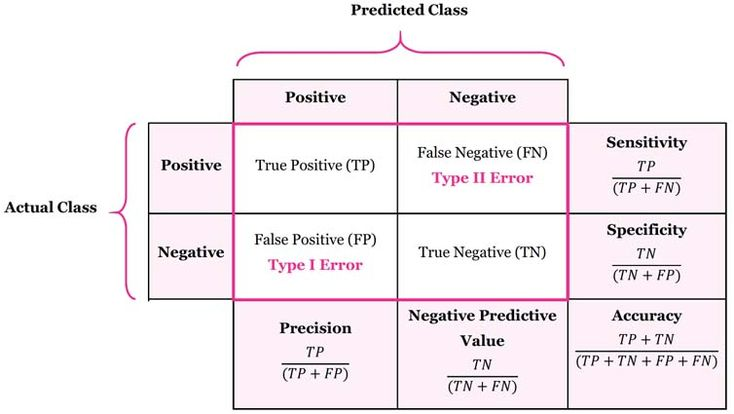

### Preprocessing

In [61]:
train_df = (
    pd.read_csv("./Feature_files/All_features_with_basic_time_feats.csv")
    .drop_duplicates()
    .sample(frac=1)
    .reset_index(drop=True)
)

In [62]:
train_df.head()

Store_Ratio  Basket_Ratio  Category_1  Store_Score  Category_2  \
0        0.836         0.537           1       -8.609           0   
1        0.631         0.715           1       -6.083           0   
2        0.282         0.547           2       -8.621           1   
3        0.180         0.555           1       -8.784           0   
4        0.597         0.931          11       -4.591           0   

   Store_Presence  Score_1  Score_2  Score_3  Score_4  popularity  weekday  \
0          0.5160  0.00128   0.1110    0.115  105.014           4        5   
1          0.0299  0.00000   0.1210    0.420  135.826           4        5   
2          0.0300  0.88800   0.1040    0.133  151.468           4        0   
3          0.2160  0.41700   0.1020    0.563  166.476           3        6   
4          0.1270  0.00000   0.0504    0.534   92.003           4        5   

   day  hour  
0    3    11  
1    3     6  
2    5    23  
3    4     6  
4    3    22

In [63]:
X = train_df.drop("popularity", axis=1)
y = train_df.popularity

### Splitting the dataset

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)

In [65]:
# Scaling X_train and X_test
scaler = MinMaxScaler(feature_range=(1, 10))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
class Modelling:
    def __init__(self, model, X_train, y_train, X_test, y_test):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.pipeline = Pipeline([("scaler", StandardScaler()), ("model", model)])

    def fit(self):
        self.pipeline.fit(self.X_train, self.y_train)

    def get_preds(self):

        check_is_fitted(estimator=self.pipeline["model"])

        return {
            "y_pred": self.pipeline.predict(self.X_test),
            "y_proba": self.pipeline.predict_proba(self.X_test),
        }

    def get_metrics(self):

        preds = self.get_preds()
        y_pred, y_proba = preds["y_pred"], preds["y_proba"]

        f1_macro = metrics.f1_score(self.y_test, y_pred, average="macro")
        report = metrics.classification_report(self.y_test, y_pred)
        recall_macro, specificity, _ = sensitivity_specificity_support(
            self.y_test, y_pred, average="macro"
        )

        print(
            f"[Recall(macro) | Sensitivity | True Positive Rate]: {round(recall_macro, 3)}"
        )
        print(f"[Specificity | True Negative Rate]: {round(specificity, 3)}")
        print(f"F1-score(macro): {round(f1_macro, 3)}")
        print(report)

        cf = metrics.confusion_matrix(self.y_test, y_pred)
        _ = sns.heatmap(
            cf,
            annot=True,
            fmt="d",
            cmap=plt.cm.Greens,
            xticklabels=np.unique(self.y_test),
            yticklabels=np.unique(self.y_test),
        )
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.suptitle(f"Confusion Matrix for {self.model.__repr__()}")
        plt.show()

        all_metrics = {
            "recall(macro)": recall_macro,
            "specificity": specificity,
            "f1(macro)": f1_macro,
            "confusion_matrix": cf,
            "classification_report": report,
        }

        return all_metrics

### Logistic Regression

Since our dataset is imbalanced, I will be using class weights such that the most amount of weightage is given to the minority class and lowest to the majority class.

In [67]:
# With balanced weights
lr_balanced = LogisticRegression(
    multi_class="multinomial",
    class_weight="balanced",
    solver="newton-cg",
)

# Vanilla LR
lr = LogisticRegression(
    multi_class="multinomial",
    solver="newton-cg",
)

[Recall(macro) | Sensitivity | True Positive Rate]: 0.404
[Specificity | True Negative Rate]: 0.807
F1-score(macro): 0.393
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.00      0.00      0.00        39
           3       0.28      0.03      0.05       268
           4       0.85      0.99      0.91      1928
           5       0.00      0.00      0.00        56

    accuracy                           0.84      2293
   macro avg       0.42      0.40      0.39      2293
weighted avg       0.74      0.84      0.77      2293



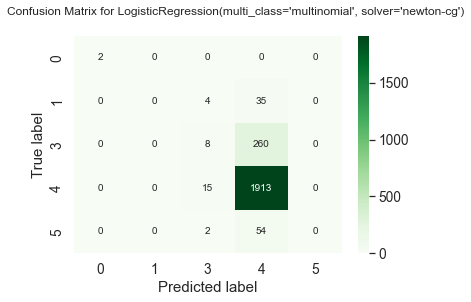

CPU times: total: 5.17 s
Wall time: 1.34 s


In [68]:
%%time
LR = Modelling(model=lr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
LR.fit()
_ = LR.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.509
[Specificity | True Negative Rate]: 0.887
F1-score(macro): 0.402
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.04      0.36      0.08        39
           3       0.23      0.28      0.25       268
           4       0.95      0.69      0.80      1928
           5       0.05      0.21      0.08        56

    accuracy                           0.63      2293
   macro avg       0.39      0.51      0.40      2293
weighted avg       0.83      0.63      0.71      2293



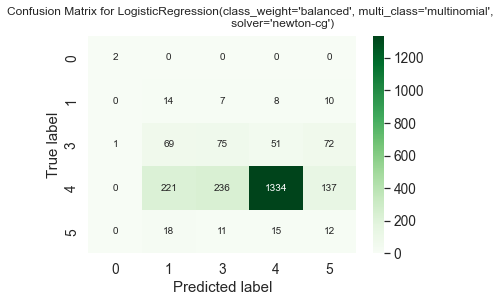

CPU times: total: 6.5 s
Wall time: 1.73 s


In [69]:
%%time
LR_BAL = Modelling(
    model=lr_balanced, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
LR_BAL.fit()
_ = LR_BAL.get_metrics()

*Obvservation*
- We can see improvement in case of LR with weight balancing. It's still pretty bad though. 
- Our Vanilla LR kind of predicts everything as `Label-4`
- There is slight improvement in LR with balanced weights as from the confusion-matrix it has started predicting other classes
- The Recall and balanced accuracy goes up for LR with weights.  

In [70]:
coef_df = pd.DataFrame(
    {
        "features": X_train.columns,
        "importances_0": np.exp(LR_BAL.model.coef_[0]),
        "importances_1": np.exp(LR_BAL.model.coef_[1]),
        "importances_3": np.exp(LR_BAL.model.coef_[2]),
        "importances_4": np.exp(LR_BAL.model.coef_[3]),
        "importances_5": np.exp(LR_BAL.model.coef_[4]),
    }
).round(2)

In [71]:
coef_df

features  importances_0  importances_1  importances_3  \
0      Store_Ratio           0.19           1.31           1.35   
1     Basket_Ratio           0.52           1.06           0.96   
2       Category_1           0.92           1.15           1.00   
3      Store_Score           1.27           0.98           0.98   
4       Category_2           1.06           1.03           1.01   
5   Store_Presence           0.77           1.21           1.18   
6          Score_1           0.99           0.98           0.98   
7          Score_2           1.27           1.09           0.93   
8          Score_3           0.64           0.97           1.17   
9          Score_4           0.02           2.33           3.15   
10         weekday           0.72           1.02           1.15   
11             day           0.38           1.12           1.36   
12            hour           0.97           1.16           0.96   

    importances_4  importances_5  
0            2.69           1.12  
1            1.81           1.03  
2            1.01           0.94  
3            0.90           0.91  
4            1.01           0.89  
5            0.88           1.04  
6            1.00           1.05  
7            0.86           0.90  
8            1.24           1.12  
9            2.41           2.82  
10           1.13           1.05  
11           1.29           1.34  
12           0.96           0.96

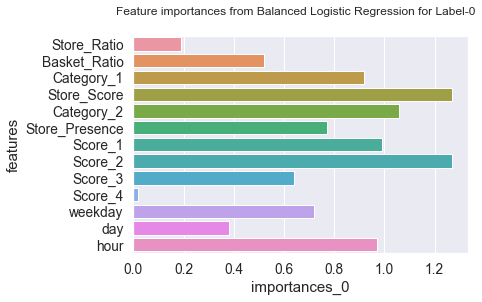

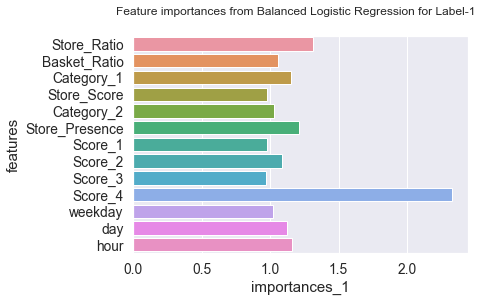

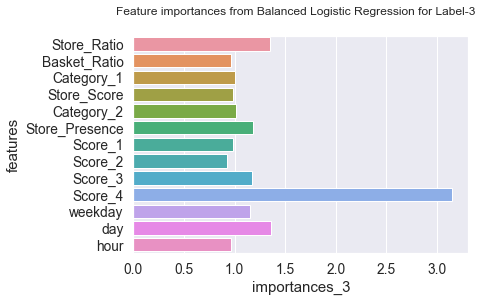

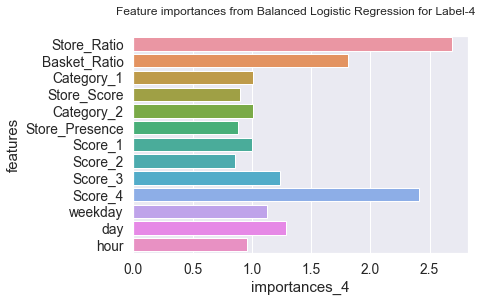

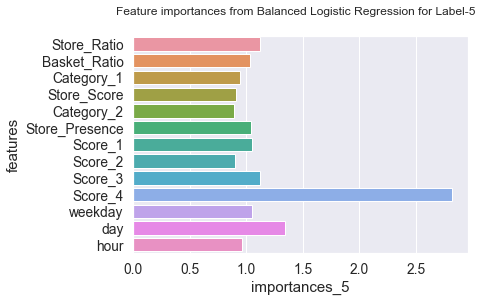

In [72]:
for col in coef_df.columns.to_list()[1:]:
    _ = sns.barplot(data=coef_df, y="features", x=col)
    plt.suptitle(
        f"Feature importances from Balanced Logistic Regression for Label-{col.split('_')[-1]}"
    )
    plt.show()

*Obvservation*
- `Score_4` is given more imprortance while classifying classes 1, 3 & 5.
- `Store_Ratio` is given more imprtance while classifying class 4
- `Store_Score` is given more imprtance while classifying class 0 

### Decision Tree

In [73]:
dt = DecisionTreeClassifier()
dt_bal = DecisionTreeClassifier(class_weight="balanced")

[Recall(macro) | Sensitivity | True Positive Rate]: 0.473
[Specificity | True Negative Rate]: 0.839
F1-score(macro): 0.473
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.17      0.15      0.16        39
           3       0.23      0.26      0.24       268
           4       0.87      0.86      0.87      1928
           5       0.09      0.09      0.09        56

    accuracy                           0.76      2293
   macro avg       0.47      0.47      0.47      2293
weighted avg       0.77      0.76      0.76      2293



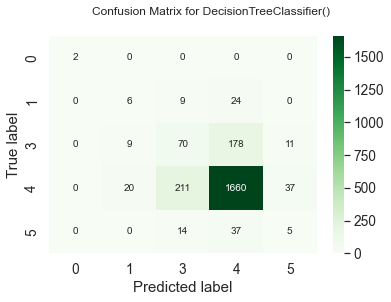

In [74]:
DT = Modelling(model=dt, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
DT.fit()
_ = DT.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.467
[Specificity | True Negative Rate]: 0.849
F1-score(macro): 0.465
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.10      0.10      0.10        39
           3       0.25      0.25      0.25       268
           4       0.88      0.88      0.88      1928
           5       0.08      0.11      0.09        56

    accuracy                           0.77      2293
   macro avg       0.46      0.47      0.47      2293
weighted avg       0.78      0.77      0.77      2293



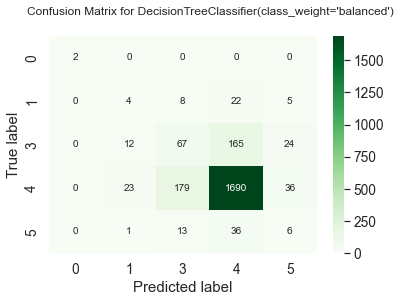

In [75]:
DT_BAL = Modelling(
    model=dt_bal, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
DT_BAL.fit()
_ = DT_BAL.get_metrics()

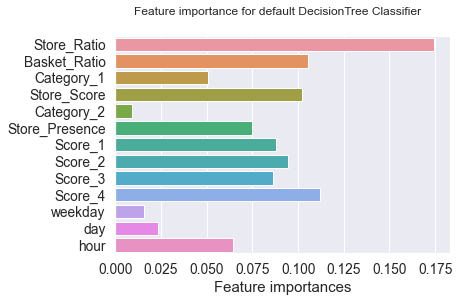

In [76]:
_ = sns.barplot(x=DT.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for default DecisionTree Classifier")
plt.show()

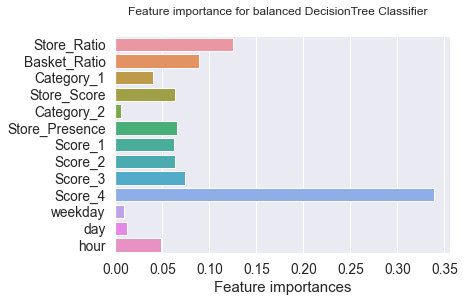

In [77]:
_ = sns.barplot(x=DT_BAL.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for balanced DecisionTree Classifier")
plt.show()

*Obvservation*
- The balanced decision tree makes decisions based on `Score_4`
- The basic decision tree puts a lot of emphasis on `Store_Ratio`

### Randomforest Classifier

In [78]:
rf_bal = RandomForestClassifier(class_weight="balanced")
rf = RandomForestClassifier()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.538
[Specificity | True Negative Rate]: 0.878
F1-score(macro): 0.267
              precision    recall  f1-score   support

           0       0.11      1.00      0.20         2
           1       0.04      0.44      0.07        39
           3       0.25      0.33      0.28       268
           4       0.96      0.53      0.69      1928
           5       0.06      0.39      0.10        56

    accuracy                           0.51      2293
   macro avg       0.28      0.54      0.27      2293
weighted avg       0.84      0.51      0.61      2293



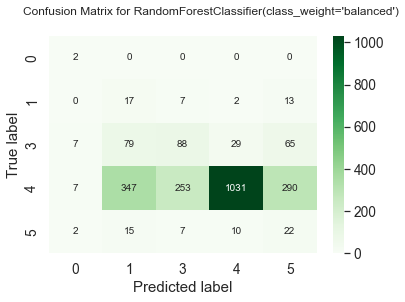

In [79]:
RF_BAL = Modelling(
    model=rf_bal, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
RF_BAL.fit()
_ = RF_BAL.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.307
[Specificity | True Negative Rate]: 0.809
F1-score(macro): 0.332
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00        39
           3       0.28      0.05      0.08       268
           4       0.85      0.99      0.91      1928
           5       0.00      0.00      0.00        56

    accuracy                           0.84      2293
   macro avg       0.42      0.31      0.33      2293
weighted avg       0.75      0.84      0.78      2293



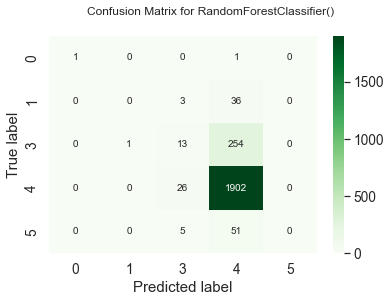

In [80]:
RF = Modelling(model=rf, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
RF.fit()
_ = RF.get_metrics()

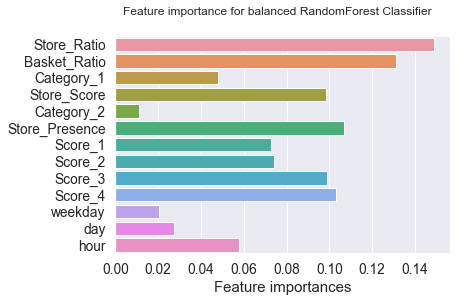

In [81]:
_ = sns.barplot(x=RF_BAL.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for balanced RandomForest Classifier")
plt.show()

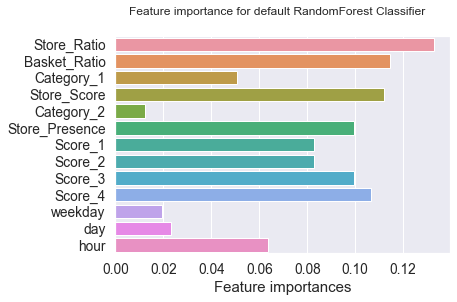

In [82]:
_ = sns.barplot(x=RF.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for default RandomForest Classifier")
plt.show()

*Obvservation*
- For Randomforest `Store_Ratio` is a very important feature

### ExtraTree Classifier

In [83]:
et_bal = ExtraTreeClassifier(class_weight="balanced")
et = ExtraTreeClassifier()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.248
[Specificity | True Negative Rate]: 0.837
F1-score(macro): 0.247
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.03      0.03      0.03        39
           3       0.23      0.25      0.24       268
           4       0.87      0.86      0.87      1928
           5       0.10      0.11      0.11        56

    accuracy                           0.75      2293
   macro avg       0.25      0.25      0.25      2293
weighted avg       0.76      0.75      0.76      2293



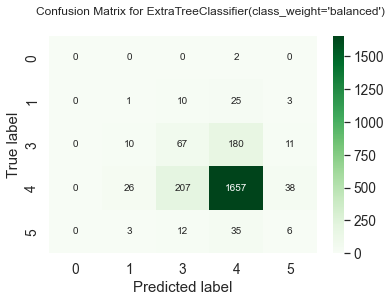

In [84]:
ET_BAL = Modelling(
    model=et_bal, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
)
ET_BAL.fit()
_ = ET_BAL.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.343
[Specificity | True Negative Rate]: 0.833
F1-score(macro): 0.374
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.06      0.08      0.07        39
           3       0.23      0.22      0.22       268
           4       0.87      0.86      0.87      1928
           5       0.05      0.05      0.05        56

    accuracy                           0.75      2293
   macro avg       0.44      0.34      0.37      2293
weighted avg       0.76      0.75      0.76      2293



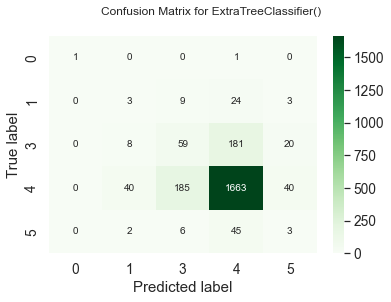

In [85]:
ET = Modelling(model=et, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
ET.fit()
_ = ET.get_metrics()

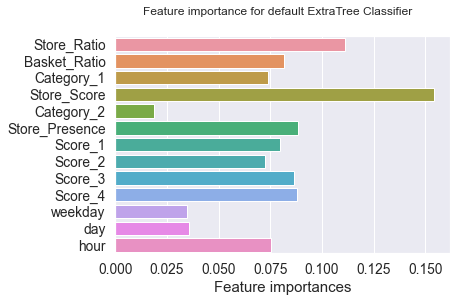

In [86]:
_ = sns.barplot(x=ET.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for default ExtraTree Classifier")
plt.show()

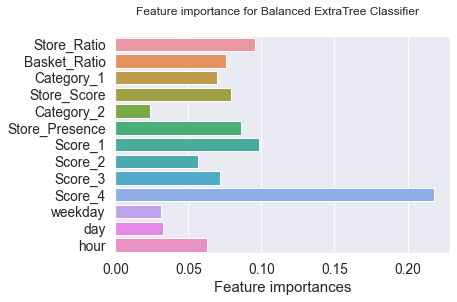

In [87]:
_ = sns.barplot(x=ET_BAL.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for Balanced ExtraTree Classifier")
plt.show()

*Obvservation*
- Default ExtraTree Classifier puts a lot of emphasis on `Store_Score`
- The balanced ExtraTree Classifier prefers `Store_Ratio` and secondly `Score_4`

> We can see a pattern, most of our classifiers using balanced weights put a lot of emphasis on `Store_Ratio` & secondly on `Score_4`  

### GradientBoosting Classifier

      Iter       Train Loss   Remaining Time 
         1           0.5296           20.99s
         2           0.5121           20.58s
         3           0.4993           19.43s
         4           0.4896           18.53s
         5           0.4819           18.05s
         6           0.4756           17.72s
         7           0.4705           17.36s
         8           0.4665           16.99s
         9           0.4631           16.70s
        10           0.4601           16.43s
        11           0.4577           16.17s
        12           0.4552           15.95s
        13           0.4531           15.71s
        14           0.4512           15.42s
        15           0.4492           15.25s
        16           0.4475           15.04s
        17           0.4463           14.87s
        18           0.4446           14.72s
        19           0.4434           14.56s
        20           0.4425           14.40s
        21           0.4412           14.24s
        2

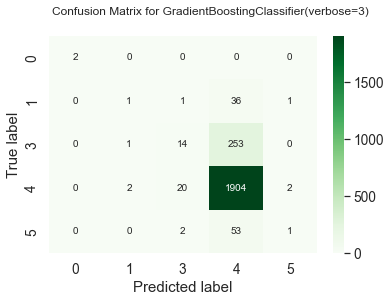

In [88]:
gb = GradientBoostingClassifier(verbose=3)
GB = Modelling(gb, X_train, y_train, X_test, y_test)
GB.fit()
_ = GB.get_metrics()

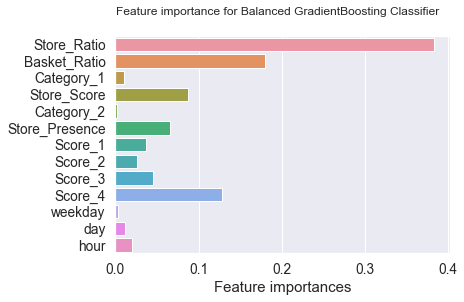

In [89]:
_ = sns.barplot(x=GB.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for Balanced GradientBoosting Classifier")
plt.show()

*Obvservation*
- `Store_Ratio` is the most important feature according to the GradientBoosting Classifier

### Light Gradient Boosting Classifier

[Recall(macro) | Sensitivity | True Positive Rate]: 0.23
[Specificity | True Negative Rate]: 0.819
F1-score(macro): 0.238
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.17      0.03      0.04        39
           3       0.34      0.10      0.16       268
           4       0.86      0.97      0.91      1928
           5       0.18      0.05      0.08        56

    accuracy                           0.83      2293
   macro avg       0.31      0.23      0.24      2293
weighted avg       0.77      0.83      0.78      2293



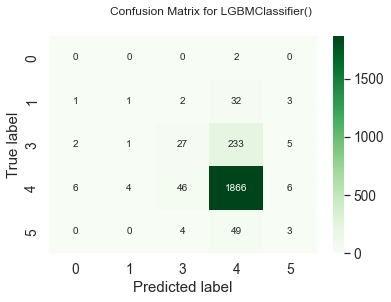

In [90]:
lgbm = lightgbm.LGBMClassifier()
LGBM = Modelling(lgbm, X_train, y_train, X_test, y_test)
LGBM.fit()
_ = LGBM.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.507
[Specificity | True Negative Rate]: 0.881
F1-score(macro): 0.477
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.11      0.13      0.12        39
           3       0.26      0.54      0.35       268
           4       0.92      0.77      0.84      1928
           5       0.07      0.09      0.08        56

    accuracy                           0.72      2293
   macro avg       0.47      0.51      0.48      2293
weighted avg       0.81      0.72      0.75      2293



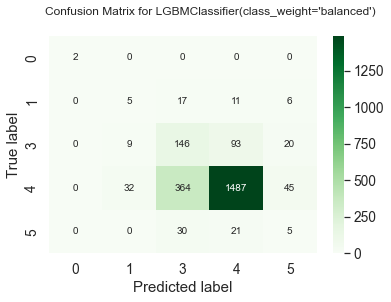

In [91]:
lgbm_bal = lightgbm.LGBMClassifier(class_weight="balanced")
LGBM_BAL = Modelling(lgbm_bal, X_train, y_train, X_test, y_test)
LGBM_BAL.fit()
_ = LGBM_BAL.get_metrics()

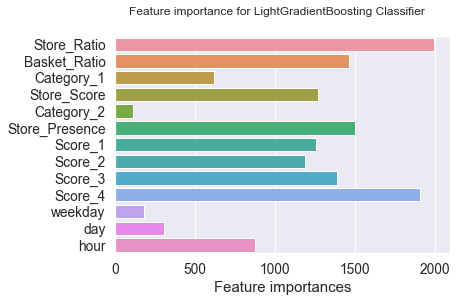

In [92]:
_ = sns.barplot(x=LGBM.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for LightGradientBoosting Classifier")
plt.show()

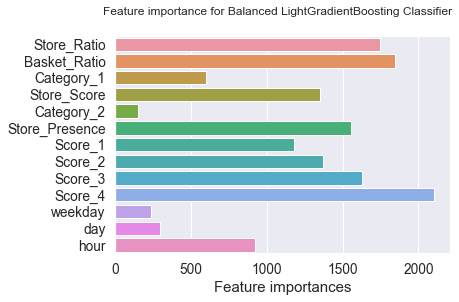

In [93]:
_ = sns.barplot(x=LGBM_BAL.model.feature_importances_, y=FEATURE_COLS)
plt.xlabel("Feature importances")
plt.suptitle("Feature importance for Balanced LightGradientBoosting Classifier")
plt.show()

*Obvservation*

- Both the light gbm classifiers put a lot of emphasis on `Store_Ratio` & `Score_4`

### Support Vector Machine

[Recall(macro) | Sensitivity | True Positive Rate]: 0.301
[Specificity | True Negative Rate]: 0.801
F1-score(macro): 0.318
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.00      0.00      0.00        39
           3       1.00      0.00      0.01       268
           4       0.84      1.00      0.91      1928
           5       0.00      0.00      0.00        56

    accuracy                           0.84      2293
   macro avg       0.57      0.30      0.32      2293
weighted avg       0.83      0.84      0.77      2293



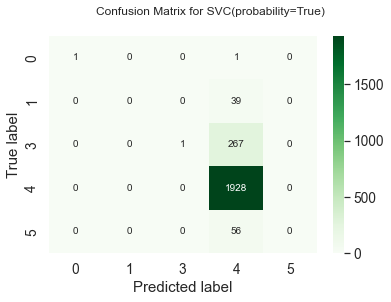

In [94]:
# Support Vector Machine with kernel='rbf' & defaults
svm = SVC(probability=True)
SVM = Modelling(svm, X_train_scaled, y_train, X_test_scaled, y_test)
SVM.fit()
_ = SVM.get_metrics()

[Recall(macro) | Sensitivity | True Positive Rate]: 0.538
[Specificity | True Negative Rate]: 0.878
F1-score(macro): 0.267
              precision    recall  f1-score   support

           0       0.11      1.00      0.20         2
           1       0.04      0.44      0.07        39
           3       0.25      0.33      0.28       268
           4       0.96      0.53      0.69      1928
           5       0.06      0.39      0.10        56

    accuracy                           0.51      2293
   macro avg       0.28      0.54      0.27      2293
weighted avg       0.84      0.51      0.61      2293



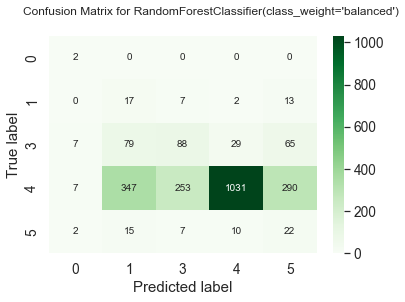

In [95]:
m = RF_BAL.get_metrics()

In [96]:
all_feat_files = list(Path("./Feature_files/").glob("*"))[1:]

In [97]:
all_feat_files

[WindowsPath('Feature_files/All_features_with_basic_time_feats.csv'),
 WindowsPath('Feature_files/Anova-10-features.csv'),
 WindowsPath('Feature_files/Anova-11-features.csv'),
 WindowsPath('Feature_files/Anova-3-features.csv'),
 WindowsPath('Feature_files/Anova-4-features.csv'),
 WindowsPath('Feature_files/Anova-5-features.csv'),
 WindowsPath('Feature_files/Anova-6-features.csv'),
 WindowsPath('Feature_files/Anova-7-features.csv'),
 WindowsPath('Feature_files/Anova-8-features.csv'),
 WindowsPath('Feature_files/Anova-9-features.csv'),
 WindowsPath('Feature_files/RFE-10-features.csv'),
 WindowsPath('Feature_files/RFE-11-features.csv'),
 WindowsPath('Feature_files/RFE-3-features.csv'),
 WindowsPath('Feature_files/RFE-4-features.csv'),
 WindowsPath('Feature_files/RFE-5-features.csv'),
 WindowsPath('Feature_files/RFE-6-features.csv'),
 WindowsPath('Feature_files/RFE-7-features.csv'),
 WindowsPath('Feature_files/RFE-8-features.csv'),
 WindowsPath('Feature_files/RFE-9-features.csv'),
 Windows

In [98]:
%%time

all_models = [lr_balanced, dt_bal, rf_bal, et_bal, lgbm_bal, gb]

fnames, models, f1s, recall_macros, specificities, cfs, creports = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

num = 1

for fname in tqdm(all_feat_files[1:]):
    df = pd.read_csv(fname)

    X = df.drop("popularity", axis=1).values
    y = df.popularity.values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

    for m in tqdm(all_models):
        print(f"Fitting model: {m} on {fname} data")
        pipeline = Pipeline([("scaler", StandardScaler()), ("model", m)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
        recall_macro, specificity, _ = sensitivity_specificity_support(
            y_test, y_pred, average="macro"
        )

        cf = metrics.confusion_matrix(y_test, y_pred)
        print("===Confusion Matrix===")
        print(cf)
        
        # print classification report
        report_dict = metrics.classification_report(y_test, y_pred, output_dict=True)
        print(metrics.classification_report(y_test, y_pred))

        # Saving the model
        model_name = m.__str__().replace(" ", "").replace("\n", "")

        with open(f"models/{model_name}_{fname.stem}.pkl", "wb") as f:
            dump(obj=pipeline["model"], file=f)

        fnames.append(fname)
        models.append(f"{model_name}_{fname.stem}.pkl")
        f1s.append(f1_macro)
        recall_macros.append(recall_macro)
        specificities.append(specificity)

performance_df = pd.DataFrame(
    {
        "file_name": fnames,
        "model_name": models,
        "f1_macro": f1s,
        "recall": recall_macros,
        "specificity": specificities,
    }
)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-10-features.csv data
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0   19   12   13   25]
 [   0   88  140   96  105]
 [   0  264  419 2131  222]
 [   0   20   30   18   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.05      0.28      0.08        69
           3       0.23      0.33      0.27       429
           4       0.94      0.70      0.81      3036
           5       0.10      0.35      0.15       105

    accuracy                           0.64      3642
   macro avg       0.46      0.53      0.46      3642
weighted avg       0.82      0.64      0.71      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-10-features.csv data
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0   33    9   2

        96           0.3887            0.80s
        97           0.3880            0.60s
        98           0.3874            0.40s
        99           0.3870            0.20s
       100           0.3859            0.00s
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0   11    2   56    0]
 [   0    3   40  385    1]
 [   0    4   28 3001    3]
 [   0    2    5   88   10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.55      0.16      0.25        69
           3       0.53      0.09      0.16       429
           4       0.85      0.99      0.91      3036
           5       0.71      0.10      0.17       105

    accuracy                           0.84      3642
   macro avg       0.73      0.47      0.50      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-11-features.csv data
===Confusion Matrix===
[[   7    0    0    0    0]
 [   0   27   18    8   16]
 [   0  118  126   98   83]
 [   0  309  426 2089  206]
 [   0   28   25   21   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.06      0.39      0.10        69
           3       0.21      0.30      0.25       425
           4       0.94      0.69      0.80      3030
           5       0.11      0.33      0.16       111

    accuracy                           0.63      3642
   macro avg       0.46      0.54      0.46      3642
weighted avg       0.82      0.63      0.70      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-11-features.csv data
===Confusion Matrix===
[[   7    0    0    0    0]
 [   0   18   16   3

        96           0.3883            0.77s
        97           0.3879            0.58s
        98           0.3872            0.39s
        99           0.3859            0.19s
       100           0.3853            0.00s
===Confusion Matrix===
[[   7    0    0    0    0]
 [   0    6    1   62    0]
 [   0    2   44  378    1]
 [   0    7   25 2993    5]
 [   0    2    9   90   10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.35      0.09      0.14        69
           3       0.56      0.10      0.17       425
           4       0.85      0.99      0.91      3030
           5       0.62      0.09      0.16       111

    accuracy                           0.84      3642
   macro avg       0.68      0.45      0.48      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-3-features.csv data
===Confusion Matrix===
[[   6    0    0    0    0]
 [   0    2   18   14   27]
 [   1   28  132  123  165]
 [   1   64  436 2205  324]
 [   1    5   24   18   48]]
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         6
           1       0.02      0.03      0.03        61
           3       0.22      0.29      0.25       449
           4       0.93      0.73      0.82      3030
           5       0.09      0.50      0.15        96

    accuracy                           0.66      3642
   macro avg       0.38      0.51      0.41      3642
weighted avg       0.81      0.66      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-3-features.csv data
===Confusion Matrix===
[[   6    0    0    0    0]
 [   0   18    9   27 

        96           0.4126            0.36s
        97           0.4123            0.27s
        98           0.4116            0.18s
        99           0.4110            0.09s
       100           0.4106            0.00s
===Confusion Matrix===
[[   6    0    0    0    0]
 [   0    3    2   55    1]
 [   0    0   41  408    0]
 [   0    3   23 3003    1]
 [   0    0    4   83    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       0.50      0.05      0.09        61
           3       0.59      0.09      0.16       449
           4       0.85      0.99      0.91      3030
           5       0.82      0.09      0.17        96

    accuracy                           0.84      3642
   macro avg       0.75      0.45      0.47      3642
weighted avg       0.81      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-4-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    6   14    9   28]
 [   1   69  134  108  117]
 [   1  121  441 2212  283]
 [   0   20   17   25   34]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.03      0.11      0.04        57
           3       0.22      0.31      0.26       429
           4       0.94      0.72      0.82      3058
           5       0.07      0.35      0.12        96

    accuracy                           0.66      3642
   macro avg       0.35      0.50      0.38      3642
weighted avg       0.82      0.66      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-4-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   17    5   34 

        97           0.4080            0.32s
        98           0.4073            0.21s
        99           0.4068            0.11s
       100           0.4062            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    4    1   50    2]
 [   0    2   33  393    1]
 [   0    3   21 3030    4]
 [   0    0    7   82    7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.44      0.07      0.12        57
           3       0.53      0.08      0.13       429
           4       0.85      0.99      0.92      3058
           5       0.50      0.07      0.13        96

    accuracy                           0.84      3642
   macro avg       0.67      0.44      0.46      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-5-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   11   13   11   19]
 [   0   83  116   98  128]
 [   0  223  418 2184  227]
 [   0   33   21   20   35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.03      0.20      0.05        54
           3       0.20      0.27      0.23       425
           4       0.94      0.72      0.81      3052
           5       0.09      0.32      0.14       109

    accuracy                           0.64      3642
   macro avg       0.45      0.50      0.45      3642
weighted avg       0.82      0.64      0.71      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-5-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   21    9   23 

        95           0.4045            0.62s
        96           0.4040            0.50s
        97           0.4032            0.37s
        98           0.4028            0.25s
        99           0.4025            0.12s
       100           0.4019            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    4    4   46    0]
 [   0    1   27  394    3]
 [   0    5    8 3035    4]
 [   0    1    6   93    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.36      0.07      0.12        54
           3       0.60      0.06      0.11       425
           4       0.85      0.99      0.92      3052
           5       0.56      0.08      0.14       109

    accuracy                           0.84      3642
   macro avg       0.68      0.44      0.46      3642
weighted avg       0.81      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-6-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    9   18    8   37]
 [   0   66  137   92  152]
 [   1  201  401 2171  260]
 [   1   14   22   22   28]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.03      0.12      0.05        72
           3       0.24      0.31      0.27       447
           4       0.95      0.72      0.82      3034
           5       0.06      0.32      0.10        87

    accuracy                           0.64      3642
   macro avg       0.35      0.49      0.38      3642
weighted avg       0.82      0.64      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-6-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   24   12   31 

        95           0.4038            0.70s
        96           0.4030            0.56s
        97           0.4025            0.42s
        98           0.4017            0.28s
        99           0.4015            0.14s
       100           0.4006            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    8    3   61    0]
 [   0    2   36  405    4]
 [   0    8   15 3008    3]
 [   0    0    7   74    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.44      0.11      0.18        72
           3       0.59      0.08      0.14       447
           4       0.85      0.99      0.91      3034
           5       0.46      0.07      0.12        87

    accuracy                           0.84      3642
   macro avg       0.67      0.45      0.47      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-7-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   17   18   12   21]
 [   0  119  129   91   72]
 [   0  312  397 2164  190]
 [   0   30   15   16   35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.04      0.25      0.06        68
           3       0.23      0.31      0.27       411
           4       0.95      0.71      0.81      3063
           5       0.11      0.36      0.17        96

    accuracy                           0.64      3642
   macro avg       0.46      0.53      0.46      3642
weighted avg       0.83      0.64      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-7-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   20   11   33 

        95           0.3947            0.83s
        96           0.3944            0.66s
        97           0.3932            0.50s
        98           0.3926            0.33s
        99           0.3921            0.17s
       100           0.3913            0.00s
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0    9    1   58    0]
 [   0    3   42  365    1]
 [   0    4   34 3024    1]
 [   0    0   14   75    7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.56      0.13      0.21        68
           3       0.46      0.10      0.17       411
           4       0.86      0.99      0.92      3063
           5       0.78      0.07      0.13        96

    accuracy                           0.85      3642
   macro avg       0.73      0.46      0.49      3642
weighted avg       0.81      0.85      0.80      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-8-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   18   11   10   21]
 [   0  100  143  110   87]
 [   0  316  384 2164  181]
 [   0   28   15   22   28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.04      0.30      0.07        60
           3       0.26      0.33      0.29       440
           4       0.94      0.71      0.81      3045
           5       0.09      0.30      0.14        93

    accuracy                           0.65      3642
   macro avg       0.46      0.53      0.46      3642
weighted avg       0.82      0.65      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-8-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   23   10   27 

        95           0.3955            0.84s
        96           0.3947            0.67s
        97           0.3941            0.51s
        98           0.3935            0.34s
        99           0.3929            0.17s
       100           0.3922            0.00s
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0    6    3   50    1]
 [   0    1   37  400    2]
 [   0    1   29 3014    1]
 [   0    0    4   78   11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.75      0.10      0.18        60
           3       0.51      0.08      0.14       440
           4       0.85      0.99      0.92      3045
           5       0.73      0.12      0.20        93

    accuracy                           0.84      3642
   macro avg       0.77      0.46      0.49      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Anova-9-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   15   16   15   20]
 [   0  107  175   83  104]
 [   0  265  419 2125  214]
 [   0   23   22   13   24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.04      0.23      0.06        66
           3       0.28      0.37      0.32       469
           4       0.95      0.70      0.81      3023
           5       0.07      0.29      0.11        82

    accuracy                           0.64      3642
   macro avg       0.47      0.52      0.46      3642
weighted avg       0.83      0.64      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Anova-9-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   20    7   38 

        96           0.3916            0.74s
        97           0.3908            0.55s
        98           0.3903            0.37s
        99           0.3898            0.18s
       100           0.3891            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    6    2   56    2]
 [   0    3   45  420    1]
 [   0    0   24 2994    5]
 [   0    0    7   66    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      0.09      0.16        66
           3       0.58      0.10      0.16       469
           4       0.85      0.99      0.91      3023
           5       0.53      0.11      0.18        82

    accuracy                           0.84      3642
   macro avg       0.72      0.46      0.48      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-10-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   24   18    5   19]
 [   0  116  120   95  104]
 [   0  375  353 2086  223]
 [   0   33   19   26   25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.04      0.36      0.08        66
           3       0.24      0.28      0.25       435
           4       0.94      0.69      0.79      3037
           5       0.07      0.24      0.11       103

    accuracy                           0.62      3642
   macro avg       0.46      0.51      0.45      3642
weighted avg       0.82      0.62      0.70      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-10-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   29   10   27   

        96           0.3855            0.79s
        97           0.3848            0.59s
        98           0.3841            0.39s
        99           0.3837            0.20s
       100           0.3832            0.00s
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   12    1   52    1]
 [   0    4   43  386    2]
 [   0    2   33 2999    3]
 [   0    1    4   88   10]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.63      0.18      0.28        66
           3       0.53      0.10      0.17       435
           4       0.85      0.99      0.91      3037
           5       0.62      0.10      0.17       103

    accuracy                           0.84      3642
   macro avg       0.73      0.47      0.51      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-11-features.csv data
===Confusion Matrix===
[[   8    0    0    0    0]
 [   0   23   14   10   22]
 [   0  136  102   93   94]
 [   0  343  348 2114  242]
 [   0   33   17   16   27]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.04      0.33      0.08        69
           3       0.21      0.24      0.23       425
           4       0.95      0.69      0.80      3047
           5       0.07      0.29      0.11        93

    accuracy                           0.62      3642
   macro avg       0.45      0.51      0.44      3642
weighted avg       0.82      0.62      0.70      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-11-features.csv data
===Confusion Matrix===
[[   8    0    0    0    0]
 [   0   27   11   27   

        95           0.3906            1.03s
        96           0.3900            0.82s
        97           0.3895            0.62s
        98           0.3889            0.41s
        99           0.3885            0.21s
       100           0.3877            0.00s
===Confusion Matrix===
[[   8    0    0    0    0]
 [   0    4    5   59    1]
 [   0    0   34  389    2]
 [   0    3   21 3021    2]
 [   0    1    3   81    8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.50      0.06      0.10        69
           3       0.54      0.08      0.14       425
           4       0.85      0.99      0.92      3047
           5       0.62      0.09      0.15        93

    accuracy                           0.84      3642
   macro avg       0.70      0.44      0.46      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-3-features.csv data
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0   18    8    8   20]
 [   0   67  147  100  112]
 [   0  240  376 2212  228]
 [   0   23   24   19   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.05      0.33      0.09        54
           3       0.26      0.35      0.30       426
           4       0.95      0.72      0.82      3056
           5       0.09      0.36      0.15       103

    accuracy                           0.66      3642
   macro avg       0.47      0.55      0.47      3642
weighted avg       0.83      0.66      0.73      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-3-features.csv data
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0   20   13   20    1

        96           0.4098            0.36s
        97           0.4095            0.27s
        98           0.4092            0.18s
        99           0.4089            0.09s
       100           0.4082            0.00s
===Confusion Matrix===
[[   3    0    0    0    0]
 [   0    5    2   47    0]
 [   0    1   36  389    0]
 [   0    1   25 3023    7]
 [   0    0    4   90    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.71      0.09      0.16        54
           3       0.54      0.08      0.15       426
           4       0.85      0.99      0.92      3056
           5       0.56      0.09      0.15       103

    accuracy                           0.84      3642
   macro avg       0.73      0.45      0.48      3642
weighted avg       0.80      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-4-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   18   11   10   17]
 [   0  128  154  107   69]
 [   0  273  391 2206  163]
 [   0   21   26   20   24]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.04      0.32      0.07        56
           3       0.26      0.34      0.30       458
           4       0.94      0.73      0.82      3033
           5       0.09      0.26      0.13        91

    accuracy                           0.66      3642
   macro avg       0.47      0.53      0.46      3642
weighted avg       0.82      0.66      0.73      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-4-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   20    4   30    2

        95           0.4008            0.54s
        96           0.4002            0.43s
        97           0.3994            0.32s
        98           0.3991            0.22s
        99           0.3986            0.11s
       100           0.3980            0.00s
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   10    3   43    0]
 [   0    2   60  393    3]
 [   0    3   34 2990    6]
 [   0    1    9   76    5]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.62      0.18      0.28        56
           3       0.57      0.13      0.21       458
           4       0.85      0.99      0.92      3033
           5       0.36      0.05      0.10        91

    accuracy                           0.84      3642
   macro avg       0.68      0.47      0.50      3642
weighted avg       0.80      0.84      0.80      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-5-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   15    7   13   16]
 [   0  125  135   78   87]
 [   0  337  394 2152  170]
 [   0   30   26   18   35]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.03      0.29      0.05        51
           3       0.24      0.32      0.27       425
           4       0.95      0.70      0.81      3053
           5       0.11      0.32      0.17       109

    accuracy                           0.64      3642
   macro avg       0.47      0.53      0.46      3642
weighted avg       0.83      0.64      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-5-features.csv data
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0   15    4   31    1

        95           0.4020            0.66s
        96           0.4016            0.52s
        97           0.4012            0.39s
        98           0.4004            0.26s
        99           0.3999            0.13s
       100           0.3991            0.00s
===Confusion Matrix===
[[   4    0    0    0    0]
 [   0    3    2   46    0]
 [   0    1   48  374    2]
 [   0    4   29 3017    3]
 [   0    2    4   91   12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.30      0.06      0.10        51
           3       0.58      0.11      0.19       425
           4       0.86      0.99      0.92      3053
           5       0.71      0.11      0.19       109

    accuracy                           0.85      3642
   macro avg       0.69      0.45      0.48      3642
weighted avg       0.81      0.85      0.80      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-6-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   22   14   10   17]
 [   0  113  161   96   87]
 [   0  250  420 2201  166]
 [   0   18   24   14   28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.05      0.35      0.09        63
           3       0.26      0.35      0.30       457
           4       0.95      0.72      0.82      3037
           5       0.09      0.33      0.15        84

    accuracy                           0.66      3642
   macro avg       0.47      0.55      0.47      3642
weighted avg       0.83      0.66      0.73      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-6-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   22   14   25    2

        95           0.4016            0.75s
        96           0.4011            0.60s
        97           0.4007            0.45s
        98           0.4002            0.30s
        99           0.3996            0.15s
       100           0.3987            0.00s
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0    5    2   56    0]
 [   0    0   43  414    0]
 [   0    3   21 3012    1]
 [   0    2    7   66    9]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.50      0.08      0.14        63
           3       0.59      0.09      0.16       457
           4       0.85      0.99      0.91      3037
           5       0.90      0.11      0.19        84

    accuracy                           0.84      3642
   macro avg       0.77      0.45      0.48      3642
weighted avg       0.81      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-7-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   18   12   15   14]
 [   0  122  164  107   74]
 [   0  317  379 2169  163]
 [   0   30   22    9   25]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.04      0.31      0.07        59
           3       0.28      0.35      0.31       467
           4       0.94      0.72      0.81      3028
           5       0.09      0.29      0.14        86

    accuracy                           0.65      3642
   macro avg       0.47      0.53      0.47      3642
weighted avg       0.82      0.65      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-7-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   19   10   29    1

        95           0.3939            0.83s
        96           0.3933            0.66s
        97           0.3930            0.50s
        98           0.3925            0.33s
        99           0.3921            0.17s
       100           0.3915            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    8    2   49    0]
 [   0    1   48  415    3]
 [   0    2   17 3005    4]
 [   0    0    3   75    8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.73      0.14      0.23        59
           3       0.69      0.10      0.18       467
           4       0.85      0.99      0.91      3028
           5       0.53      0.09      0.16        86

    accuracy                           0.84      3642
   macro avg       0.76      0.46      0.50      3642
weighted avg       0.82      0.84      0.79      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-8-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   17   20   15   12]
 [   0   96  169  117   75]
 [   0  279  410 2182  164]
 [   0   27   22   18   18]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.04      0.27      0.07        64
           3       0.27      0.37      0.31       457
           4       0.94      0.72      0.81      3035
           5       0.07      0.21      0.10        85

    accuracy                           0.66      3642
   macro avg       0.46      0.51      0.46      3642
weighted avg       0.82      0.66      0.72      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-8-features.csv data
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0   22    9   32    1

        95           0.3890            0.90s
        96           0.3884            0.72s
        97           0.3878            0.54s
        98           0.3872            0.36s
        99           0.3867            0.18s
       100           0.3862            0.00s
===Confusion Matrix===
[[   1    0    0    0    0]
 [   0    6    1   54    3]
 [   0    1   57  398    1]
 [   0    8   18 3005    4]
 [   0    1   11   67    6]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       0.38      0.09      0.15        64
           3       0.66      0.12      0.21       457
           4       0.85      0.99      0.92      3035
           5       0.43      0.07      0.12        85

    accuracy                           0.84      3642
   macro avg       0.66      0.46      0.48      3642
weighted avg       0.81      0.84      0.80      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\RFE-9-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   29   13    9   14]
 [   0  117  106   83  109]
 [   0  330  354 2159  218]
 [   0   28   22   23   26]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.06      0.45      0.10        65
           3       0.21      0.26      0.23       415
           4       0.95      0.71      0.81      3061
           5       0.07      0.26      0.11        99

    accuracy                           0.64      3642
   macro avg       0.46      0.53      0.45      3642
weighted avg       0.83      0.64      0.71      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\RFE-9-features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   26    9   29    1

        95           0.3953            0.94s
        96           0.3945            0.75s
        97           0.3935            0.56s
        98           0.3930            0.38s
        99           0.3926            0.19s
       100           0.3923            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    6    3   56    0]
 [   0    0   47  368    0]
 [   0    4   25 3031    1]
 [   0    0    6   82   11]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.60      0.09      0.16        65
           3       0.58      0.11      0.19       415
           4       0.86      0.99      0.92      3061
           5       0.92      0.11      0.20        99

    accuracy                           0.85      3642
   macro avg       0.79      0.46      0.49      3642
weighted avg       0.82      0.85      0.80      3642



  0%|          | 0/6 [00:00<?, ?it/s]

Fitting model: LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg') on Feature_files\Variance_thresholded_features.csv data
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0   25   17   19   20]
 [   0  126  119   96   97]
 [   0  334  373 2103  221]
 [   0   27   14   20   29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.05      0.31      0.08        81
           3       0.23      0.27      0.25       438
           4       0.94      0.69      0.80      3031
           5       0.08      0.32      0.13        90

    accuracy                           0.63      3642
   macro avg       0.46      0.52      0.45      3642
weighted avg       0.81      0.63      0.70      3642

Fitting model: DecisionTreeClassifier(class_weight='balanced') on Feature_files\Variance_thresholded_features.csv data
===Confusion Matrix===
[[   2    0    0    0   

        93           0.3863            1.34s
        94           0.3853            1.15s
        95           0.3846            0.95s
        96           0.3839            0.76s
        97           0.3834            0.57s
        98           0.3829            0.38s
        99           0.3821            0.19s
       100           0.3817            0.00s
===Confusion Matrix===
[[   2    0    0    0    0]
 [   0    9    3   69    0]
 [   0    2   45  391    0]
 [   0    2   22 3005    2]
 [   0    0    6   82    2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.69      0.11      0.19        81
           3       0.59      0.10      0.18       438
           4       0.85      0.99      0.91      3031
           5       0.50      0.02      0.04        90

    accuracy                           0.84      3642
   macro avg       0.73      0.45      0.46      3642
weighted avg       0.80      0.84      0.7

In [99]:
pd.set_option("display.max_rows", None)
performance_df = performance_df.sort_values(by="f1_macro", ascending=False).reset_index(
    drop=True
)
performance_df

file_name  \
0                Feature_files\Anova-10-features.csv   
1                   Feature_files\RFE-6-features.csv   
2                  Feature_files\RFE-10-features.csv   
3                 Feature_files\Anova-6-features.csv   
4                Feature_files\Anova-10-features.csv   
5                Feature_files\Anova-10-features.csv   
6                 Feature_files\Anova-3-features.csv   
7                   Feature_files\RFE-3-features.csv   
8                   Feature_files\RFE-6-features.csv   
9                 Feature_files\Anova-6-features.csv   
10                  Feature_files\RFE-8-features.csv   
11                  Feature_files\RFE-9-features.csv   
12                 Feature_files\RFE-11-features.csv   
13                  Feature_files\RFE-9-features.csv   
14                 Feature_files\RFE-11-features.csv   
15                Feature_files\Anova-3-features.csv   
16                  Feature_files\RFE-7-features.csv   
17                Feature_files\Anova-8-features.csv   
18                  Feature_files\RFE-4-features.csv   
19                  Feature_files\RFE-5-features.csv   
20                Feature_files\Anova-9-features.csv   
21               Feature_files\Anova-11-features.csv   
22   Feature_files\Variance_thresholded_features.csv   
23                Feature_files\Anova-7-features.csv   
24                  Feature_files\RFE-8-features.csv   
25   Feature_files\Variance_thresholded_features.csv   
26   Feature_files\Variance_thresholded_features.csv   
27                Feature_files\Anova-5-features.csv   
28                  Feature_files\RFE-4-features.csv   
29               Feature_files\Anova-11-features.csv   
30                  Feature_files\RFE-5-features.csv   
31               Feature_files\Anova-11-features.csv   
32                Feature_files\Anova-9-features.csv   
33                Feature_files\Anova-4-features.csv   
34                 Feature_files\RFE-11-features.csv   
35                Feature_files\Anova-7-features.csv   
36                Feature_files\Anova-8-features.csv   
37                  Feature_files\RFE-6-features.csv   
38                Feature_files\Anova-4-features.csv   
39                Feature_files\Anova-5-features.csv   
40                  Feature_files\RFE-7-features.csv   
41                Feature_files\Anova-9-features.csv   
42                  Feature_files\RFE-9-features.csv   
43                Feature_files\Anova-8-features.csv   
44                  Feature_files\RFE-5-features.csv   
45                  Feature_files\RFE-3-features.csv   
46                  Feature_files\RFE-7-features.csv   
47                 Feature_files\RFE-10-features.csv   
48                Feature_files\Anova-5-features.csv   
49                 Feature_files\RFE-10-features.csv   
50                  Feature_files\RFE-8-features.csv   
51                Feature_files\Anova-7-features.csv   
52                  Feature_files\RFE-3-features.csv   
53                Feature_files\Anova-6-features.csv   
54                  Feature_files\RFE-4-features.csv   
55                 Feature_files\RFE-10-features.csv   
56                  Feature_files\RFE-4-features.csv   
57               Feature_files\Anova-10-features.csv   
58                  Feature_files\RFE-7-features.csv   
59                  Feature_files\RFE-9-features.csv   
60                Feature_files\Anova-8-features.csv   
61                Feature_files\Anova-7-features.csv   
62                Feature_files\Anova-9-features.csv   
63                  Feature_files\RFE-6-features.csv   
64                  Feature_files\RFE-8-features.csv   
65                  Feature_files\RFE-5-features.csv   
66               Feature_files\Anova-11-features.csv   
67                  Feature_files\RFE-3-features.csv   
68                  Feature_files\RFE-6-features.csv   
69                  Feature_files\RFE-3-features.csv   
70                Feature_files\Anova-6-features.csv   
71         

In [101]:
performance_df.iloc[0, :]["model_name"]

"DecisionTreeClassifier(class_weight='balanced')_Anova-10-features.pkl"

In [102]:
performance_df.iloc[0, :]["file_name"]

WindowsPath('Feature_files/Anova-10-features.csv')

In [103]:
performance_df.to_csv("performance(simple-fit).csv", index=False)

### Save all splits

In [111]:
# Save all splits

# Save `X_train`
with open("train_test_data/X_train.pkl", "wb") as f:
    dump(obj=X_train, file=f)

# Save `X_train_scaled`
with open("train_test_data/X_train_scaled.pkl", "wb") as f:
    dump(obj=X_train_scaled, file=f)

# Save `X_test`
with open("train_test_data/X_test.pkl", "wb") as f:
    dump(obj=X_test, file=f)

# Save `y_train`
with open("train_test_data/y_train.pkl", "wb") as f:
    dump(obj=y_train, file=f)

# Save `y_test`
with open("train_test_data/y_test.pkl", "wb") as f:
    dump(obj=y_test, file=f)

## Cross - validation

In [104]:
all_models

[LogisticRegression(class_weight='balanced', multi_class='multinomial',
                    solver='newton-cg'),
 DecisionTreeClassifier(class_weight='balanced'),
 RandomForestClassifier(class_weight='balanced'),
 ExtraTreeClassifier(class_weight='balanced'),
 LGBMClassifier(class_weight='balanced'),
 GradientBoostingClassifier(verbose=3)]

In [112]:
# Saving models
with open("all_models.pkl", "wb") as f:
    dump(obj=all_models, file=f)

### Load train-test splits

In [10]:
with open("train_test_data/X_train.pkl", "rb") as f:
    X_train = load(file=f)
    print(X_train.shape)

with open("train_test_data/X_train_scaled.pkl", "rb") as f:
    X_train_scaled = load(file=f)
    print(X_train_scaled.shape)

with open("train_test_data/y_train.pkl", "rb") as f:
    y_train = load(file=f)
    print(y_train.shape)
    
with open("train_test_data/X_test.pkl", "rb") as f:
    X_test = load(file=f)
    print(X_test.shape)
    
with open("train_test_data/y_test.pkl", "rb") as f:
    y_test = load(file=f)
    print(y_test.shape)

(14566, 12)
(14566, 12)
(14566,)
(3642, 12)
(3642,)


In [11]:
with open("all_models.pkl", "rb") as f:
    all_models = load(file=f)
    print(all_models)

[LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   solver='newton-cg'), DecisionTreeClassifier(class_weight='balanced'), RandomForestClassifier(class_weight='balanced'), ExtraTreeClassifier(class_weight='balanced'), LGBMClassifier(class_weight='balanced'), GradientBoostingClassifier(verbose=3)]


In [18]:
f1_macro_scorer = metrics.make_scorer(metrics.f1_score, average="macro")
recall_macro = metrics.make_scorer(metrics.recall_score, average="macro")

In [19]:
%%time
lr_cv_dict = cross_validate(
    estimator=all_models[0],
    X=X_train,
    y=y_train,
    cv=5,
    scoring={
        "f1_macro": f1_macro_scorer,
        "recal_macro": recall_macro
    },
    verbose=3,
    n_jobs=-1,
    return_estimator=True,
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   10.9s remaining:   16.4s


CPU times: total: 62.5 ms
Wall time: 13.6 s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.4s finished


In [20]:
lr_cv_dict

{'fit_time': array([10.73360586,  9.80856133,  8.21956754,  6.48556328,  8.42755723]),
 'score_time': array([0.18999243, 0.21800733, 0.24399543, 0.27400374, 0.24599957]),
 'estimator': [LogisticRegression(class_weight='balanced', multi_class='multinomial',
                     solver='newton-cg'),
  LogisticRegression(class_weight='balanced', multi_class='multinomial',
                     solver='newton-cg'),
  LogisticRegression(class_weight='balanced', multi_class='multinomial',
                     solver='newton-cg'),
  LogisticRegression(class_weight='balanced', multi_class='multinomial',
                     solver='newton-cg'),
  LogisticRegression(class_weight='balanced', multi_class='multinomial',
                     solver='newton-cg')],
 'test_f1_macro': array([0.45372602, 0.45160614, 0.4521958 , 0.45837086, 0.44983923]),
 'test_recal_macro': array([0.53325352, 0.52551275, 0.52324147, 0.54158984, 0.51926287])}

In [15]:
y_pred = lr_cv_dict['estimator'][3].predict(X_test)

In [17]:
sensitivity_specificity_support(y_test, y_pred)

(array([1.        , 0.33333333, 0.25114155, 0.69383042, 0.32222222]),
 array([1.        , 0.85565852, 0.8829588 , 0.77577741, 0.90287162]),
 array([   2,   81,  438, 3031,   90], dtype=int64))

In [ ]:
for fname in tqdm(all_feat_files[1:]):
    df = pd.read_csv(fname)

    for m in tqdm(all_models[1:]):
        print(f"Fitting model: {m} on {fname} data")
        

        # Saving the model
        model_name = m.__str__().replace(" ", "").replace("\n", "")

        with open(f"models/{model_name}_CV_{fname.stem}.pkl", "wb") as f:
            dump(obj=pipeline["model"], file=f)

        fnames.append(fname)
        models.append(f"{model_name}_{fname.stem}.pkl")
        f1s.append(f1_macro)
        recall_macros.append(recall_macro)
        specificities.append(specificity)

performance_df = pd.DataFrame(
    {
        "file_name": fnames,
        "model_name": models,
        "f1_macro": f1s,
        "recall": recall_macros,
        "specificity": specificities,
    }
)    

## Hyperparameter Tuning